# Reproduciable Analysis

Initial code for FSDS Data+PolicyBriefing assignment

By: Group BraCoChi

## Coding Structure:

    Libraries
    
    1. Lodaing data
      1.1 Loading price data
      1.2 Loading Elizabeth line shapefile (stations and track) 
      1.3 Loading London borough data
      
    2. Cleaning data 
      2.1 Reprojection
      2.2 Cleaning Airbnb dataset
        2.2.1 Dealing with NaNs and Nulls 
        2.2.2 Dealing with srings ('price') 
        
    3. Manipulating Data
      3.1 Short-term rental data (Airbnb data)
        3.1.1 Calculating global increasing rate
        3.1.2 Calculating increasing rate by boroughs
        3.1.3 Choosing the boroughs through which the Elizabeth Line passes
      3.2 Long-term rental data
        3.2.1 Calculating global increasing rate
        3.2.2 Calculating increasing rate by boroughs
        3.2.3 Choosing the boroughs through which the Elizabeth Line passes
     
    4. Mapping
       4.1 Short-term market (Airbnb)
       4.2 Long-term market
       
    5. Description analysis 
    
    6. Radius analysis for airbnb listing prices
    
    7. Zone analysis for airbnb listing prices 


## Libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import colors
import shapely as sa
#from pandas_profiling import ProfileReport
import fiona
import requests

## Loading the data 

In [2]:
# check the current work path
os.getcwd()

'/home/jovyan/work/OneDrive/Documentos/GitHub/BraCoChi_codes'

In [3]:
path = os.getcwd() + '/raw_data/'
path

'/home/jovyan/work/OneDrive/Documentos/GitHub/BraCoChi_codes/raw_data/'

In [4]:
# Short-term rental price (Airbnb dataset for 2020 and 2022)
# Read in the raw data from 2022 Airbnb listing
airbnb_22_raw = pd.read_csv(path + 'Airbnb/raw/listings.csv')

# The raw data from 2020 Airbnb listing
airbnb_20_raw = pd.read_csv(path + 'Airbnb/raw/2020-08-24-listings.csv')

/tmp/ipykernel_8516/858560840.py:6: DtypeWarning: Columns (2,22,36,41,45,46,55) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_20_raw = pd.read_csv(path + 'Airbnb/raw/2020-08-24-listings.csv')


In [5]:
# Long-term rental price
longterm_rental_raw = pd.read_csv(path + 'Long-term data (rental price & house price)/rent_price_borough.csv')

In [6]:
# The London excluding MHW boundries
London_ex_raw = gpd.read_file(path + 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

In [7]:
# Load the shape files
# The OA London boundaries
London_raw = gpd.read_file(path + 'statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp')
# load the Elizabeth Line stations shape files
el_station_raw = gpd.read_file(path + 'Elizabeth_line_shapefile/CRL_Stations.shp')
# load the Elizabeth Line track shape files
el_track_raw = gpd.read_file(path + 'Elizabeth_line_shapefile/CRL_Track.shp')

In [8]:
# Load the TFL fare zones data (6 zones)
zones_raw = pd.read_csv(path + 'MyLondon_fare_zone_OA.csv')

## Long term rental prices analysis 

In [9]:
# Wd

### 1.1 Loading price data 

In [10]:
# Long-term rental price (per month, median price, by borough)
longterm_rental = longterm_rental_raw.copy()

# Short-term rental price (Airbnb dataset for 2020 and 2022)
airbnb_2020 = airbnb_20_raw.copy()
airbnb_2022 = airbnb_22_raw.copy()

### 1.2 Loading Elizabeth line shapefile (stations and track) 

   OBJECTID   STATION_NA  SIZE_ SE_ANNO_CA                       geometry
0         1  Forest Gate  Small       None  POINT (540409.113 185311.628)
1         2   Manor Park  Small       None  POINT (541906.079 185683.241)
2         3       Ilford  Small       None  POINT (543515.859 186487.354)
3         4  Seven Kings  Small       None  POINT (545384.047 187089.399)
4         5    Goodmayes  Small       None  POINT (546470.589 187325.404)


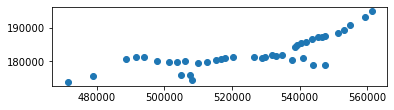

In [11]:
# Loading stations shapefile
stations = el_station_raw.copy()
stations.head()    
stations.plot()

print(stations.head())

   OBJECTID     ROUTEDESC    BRANCHDESC DIRECTDESC  \
0         1  Network Rail  Western Spur  Eastbound   
1         2  Network Rail  Western Spur  Eastbound   
2         3  Network Rail  Western Spur  Eastbound   
3         4  Network Rail  Western Spur  Eastbound   
4         5  Network Rail  Western Spur  Eastbound   

                                            geometry  
0  LINESTRING (521936.314 182273.252, 521935.366 ...  
1  LINESTRING (521959.564 182241.351, 521958.663 ...  
2  LINESTRING (521970.633 182264.311, 521969.731 ...  
3  LINESTRING (521961.418 182303.518, 521960.645 ...  
4  LINESTRING (521953.921 182240.761, 521952.973 ...  


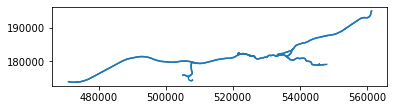

In [12]:
# Loading track shapefile
track = el_track_raw.copy()
track.head()    
track.plot()

print(track.head())

### 1.3 Loading London borough data 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   SUB_2009    0 non-null      object  
 6   SUB_2006    0 non-null      object  
 7   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 2.2+ KB
None


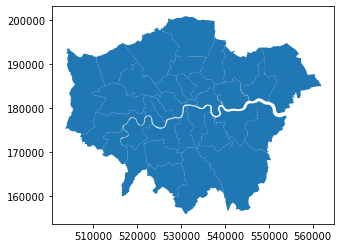

In [13]:
borough = London_ex_raw.copy()
borough.head()   
borough.plot()

print(borough.info(verbose=True))

## 2. Cleaning data 

### 2.1 Reprojection 

In [14]:
# Detecting crs
print(borough.crs)
print(stations.crs)
print(track.crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
epsg:27700
epsg:27700


In [15]:
# Reproject them to EPSG 27700 (British National Grid)
borough= borough.to_crs('epsg:27700')
stations = stations.to_crs('epsg:27700')
track = track.to_crs('epsg:27700')

print(borough.crs)
print(stations.crs)
print(track.crs)

epsg:27700
epsg:27700
epsg:27700


### 2.2 Cleaning Airbnb dataset

#### 2.2.1 Dealing with NaNs and Nulls 

In [16]:
airbnb_2020[airbnb_2020.price.isna()]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3558,3138549.0,https://www.airbnb.com/rooms/3138549,20200824024753.0,2020-08-26,Heart of City of London/Shoreditch,Our lovely flat is in a newly designed buildin...,"Old Street is in the heart of Shoreditch, with...",https://a0.muscache.com/pictures/ed787e5d-730c...,4968944.0,https://www.airbnb.com/users/show/4968944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29989,21549106.0,https://www.airbnb.com/rooms/21549106,20200824024753,2020-08-27,"Richmond Luxury, High ceilings & Free Parking",Welcome to my Richmond (not East Twickenham) b...,Richmond is famous for its Royal parks & impre...,https://a0.muscache.com/pictures/355d8a17-8d9e...,123942428.0,https://www.airbnb.com/users/show/123942428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
airbnb_2022[airbnb_2022.price.isna()]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [18]:
airbnb_2020[~(airbnb_2020.price.str.startswith('$', na=False))]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3558,3138549.0,https://www.airbnb.com/rooms/3138549,20200824024753.0,2020-08-26,Heart of City of London/Shoreditch,Our lovely flat is in a newly designed buildin...,"Old Street is in the heart of Shoreditch, with...",https://a0.muscache.com/pictures/ed787e5d-730c...,4968944.0,https://www.airbnb.com/users/show/4968944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3559,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1c171...,https://a0.muscache.com/im/pictures/user/1c171...,Shoreditch,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29989,21549106.0,https://www.airbnb.com/rooms/21549106,20200824024753,2020-08-27,"Richmond Luxury, High ceilings & Free Parking",Welcome to my Richmond (not East Twickenham) b...,Richmond is famous for its Royal parks & impre...,https://a0.muscache.com/pictures/355d8a17-8d9e...,123942428.0,https://www.airbnb.com/users/show/123942428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29990,NaN,within an hour,100%,74%,f,https://a0.muscache.com/im/pictures/user/19315...,https://a0.muscache.com/im/pictures/user/19315...,Richmond,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
airbnb_2022[~(airbnb_2022.price.str.startswith('$', na=False))]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [20]:
airbnb_2020[airbnb_2020.id.isna()][['id','listing_url','name','description','host_id','host_name','price']]

,id,listing_url,name,description,host_id,host_name,price
3559,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1c171...,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",0
29990,NaN,within an hour,f,https://a0.muscache.com/im/pictures/user/19315...,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",10


In [21]:
airbnb_2022[airbnb_2022.id.isna()][['id','listing_url','name','description','host_id','host_name','price']]

,id,listing_url,name,description,host_id,host_name,price


In [22]:
airbnb_2020[airbnb_2020.neighbourhood_cleansed.isna()]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3558,3138549.0,https://www.airbnb.com/rooms/3138549,20200824024753.0,2020-08-26,Heart of City of London/Shoreditch,Our lovely flat is in a newly designed buildin...,"Old Street is in the heart of Shoreditch, with...",https://a0.muscache.com/pictures/ed787e5d-730c...,4968944.0,https://www.airbnb.com/users/show/4968944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29989,21549106.0,https://www.airbnb.com/rooms/21549106,20200824024753,2020-08-27,"Richmond Luxury, High ceilings & Free Parking",Welcome to my Richmond (not East Twickenham) b...,Richmond is famous for its Royal parks & impre...,https://a0.muscache.com/pictures/355d8a17-8d9e...,123942428.0,https://www.airbnb.com/users/show/123942428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
airbnb_2022[airbnb_2022.neighbourhood_cleansed.isna()]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [24]:
# Dropping the NaNs and Nulls in column 'id', 'price', 'neighbourhood_cleansed'
airbnb_2020.drop(airbnb_2020[airbnb_2020.id.isna()].index.array, axis=0, inplace=True)
airbnb_2022.drop(airbnb_2022[airbnb_2022.id.isna()].index.array, axis=0, inplace=True)

airbnb_2020.drop(airbnb_2020[airbnb_2020.price.isna()].index.array, axis=0, inplace=True)
airbnb_2022.drop(airbnb_2022[airbnb_2022.price.isna()].index.array, axis=0, inplace=True)

airbnb_2020.drop(airbnb_2020[airbnb_2020.neighbourhood_cleansed.isna()].index.array, axis=0, inplace=True)
airbnb_2022.drop(airbnb_2022[airbnb_2022.neighbourhood_cleansed.isna()].index.array, axis=0, inplace=True)

#### 2.2.2 Dealing with srtings (price)

In [25]:
money = ['price']
airbnb_2020.sample(5, random_state=42)[money]

,price
66121,$89.00
58701,$125.00
53195,$27.00
64796,$169.00
46074,$70.00


In [26]:
# Convering price for Airbnb2020 dataset
for m in money:
    print(f"Converting {m}")
    airbnb_2020[m] = airbnb_2020[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [27]:
# Convering price for Airbnb2022 dataset
for m in money:
    print(f"Converting {m}")
    airbnb_2022[m] = airbnb_2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

Converting price


In [28]:
# Check
airbnb_2020.sample(5, random_state=42)[money]

,price
66121,89.0
58701,125.0
53195,27.0
64796,169.0
46074,70.0


In [29]:
# Check
airbnb_2022.sample(5, random_state=42)[money]

,price
26643,22.0
15713,450.0
67606,175.0
40703,214.0
625,50.0


## 3. Manipulating Data 

### 3.1 Short-term rental data (Airbnb data)

#### 3.1.1 Calculating global increasing rate 

In [30]:
# Calculating the global increasing rate
year2020 = airbnb_2020['price'].median()
year2022 = airbnb_2022['price'].median()

global_airbnb = ((year2022-year2020)/(year2020))*100
global_airbnb

26.582278481012654

#### 3.1.2 Calculating increasing rate by boroughs

In [31]:
# Grouping airbnb data by boroughs and each calculating the median price of each groups
airbnb_2020_grouped = airbnb_2020.groupby('neighbourhood_cleansed')['price'].median()
airbnb_2022_grouped = airbnb_2022.groupby('neighbourhood_cleansed')['price'].median()

In [32]:
# Converting series to dataframe, and renaming column name in order to avoid duplication when combining two dataset
airbnb_2020_grouped = airbnb_2020_grouped.to_frame()
airbnb_2020_grouped = airbnb_2020_grouped.rename(columns = {"price": "price2020"})
airbnb_2022_grouped = airbnb_2022_grouped.to_frame()
airbnb_2022_grouped = airbnb_2022_grouped.rename(columns = {"price": "price2022"})

In [33]:
# Combining two dataset
airbnb = pd.concat([airbnb_2020_grouped,airbnb_2022_grouped],axis=1)

# Renaming the borough column to make the subsequent merge easier
airbnb.rename(columns = {"neighbourhood_cleansed": "GSS_CODE"})

,price2020,price2022
neighbourhood_cleansed,,
Barking and Dagenham,43.0,60.0
Barnet,55.0,80.0
Bexley,39.0,60.0
Brent,61.0,85.0
Bromley,50.0,70.0
Camden,94.0,125.0
City of London,125.0,196.0
Croydon,40.0,60.0
Ealing,50.0,70.0


In [34]:
# Calculating the increase rate 
increase_rate_airbnb = ((airbnb['price2022']-airbnb['price2020'])/(airbnb['price2020']))*100

# Adding as a new column
s = pd.Series(increase_rate_airbnb)
airbnb.insert(2, 'increase_rate_airbnb', s)

# Converting data to percentage
# airbnb[u'increase_rate_airbnb'] = airbnb[u'increase_rate_airbnb'].apply(lambda x: format(x, '.0%'))
airbnb

,price2020,price2022,increase_rate_airbnb
neighbourhood_cleansed,,,
Barking and Dagenham,43.0,60.0,39.534884
Barnet,55.0,80.0,45.454545
Bexley,39.0,60.0,53.846154
Brent,61.0,85.0,39.344262
Bromley,50.0,70.0,40.000000
Camden,94.0,125.0,32.978723
City of London,125.0,196.0,56.800000
Croydon,40.0,60.0,50.000000
Ealing,50.0,70.0,40.000000


In [35]:
airbnb = airbnb.reset_index()
airbnb = airbnb.rename(columns={'neighbourhood_cleansed':'NAME'})

#### 3.1.3 Choosing the boroughs through which the Elizabeth Line passes

In [36]:
# Choose the boroughs through which the Elizabeth Line passes
list_one=['Westminster','Hillingdon','Ealing','Hammersmith and Fulham','Kensington and Chelsea','Camden','Islington','City of London','Tower Hamlets','Newham','Greenwich','Redbridge','Barking and Dagenham','Havering']
airbnb_choose = airbnb[(airbnb['NAME'].isin(list_one))]
airbnb_choose

,NAME,price2020,price2022,increase_rate_airbnb
0,Barking and Dagenham,43.0,60.0,39.534884
5,Camden,94.0,125.0,32.978723
6,City of London,125.0,196.0,56.800000
8,Ealing,50.0,70.0,40.000000
10,Greenwich,61.0,80.0,31.147541
12,Hammersmith and Fulham,90.0,112.5,25.000000
15,Havering,49.0,70.0,42.857143
16,Hillingdon,45.0,68.0,51.111111
18,Islington,84.0,99.0,17.857143
19,Kensington and Chelsea,128.0,186.0,45.312500


### 3.2 Long-term rental data

#### 3.2.1 Calculating global increasing rate

In [37]:
# Calculating the global increasing rate
year2020_long = longterm_rental['median_2020'].median()
year2022_long = longterm_rental['median_2022'].median()

global_increase_rate_longterm = ((year2022_long-year2020_long)/(year2020_long))*100
global_increase_rate_longterm

4.145077720207254

#### 3.2.2 Calculating increasing rate by boroughs

In [38]:
# Calculating the increase rate 
increase_rate_longterm = ((longterm_rental['median_2022']-longterm_rental['median_2020'])/(longterm_rental['median_2020']))*100

# Adding as a new column
s = pd.Series(increase_rate_longterm)
longterm_rental.insert(4, 'increase_rate_longterm', s)

# Converting data to percentage
#rent_price_merge[u'increase_rate_rent'] = rent_price_merge[u'increase_rate_rent'].apply(lambda x: format(x, '.2%'))

longterm_rental

,borough_name,code,median_2020,median_2022,increase_rate_longterm
0,Barking and Dagenham,E09000002,1104,1150,4.166667
1,Barnet,E09000003,1532,1416,-7.571802
2,Bexley,E09000004,990,1151,16.262626
3,Brent,E09000005,1339,1352,0.970874
4,Bromley,E09000006,1183,1291,9.129332
5,Camden,E09000007,1921,2217,15.408641
6,City of London,E09000001,1998,1851,-7.357357
7,Croydon,E09000008,1128,1171,3.812057
8,Ealing,E09000009,1458,1448,-0.685871
9,Enfield,E09000010,1294,1242,-4.018547


In [39]:
# Renaming column 'borough_name' to 'NAME' in order to merge with borough dataset
longterm_rental = longterm_rental.rename(columns={'borough_name':'NAME'})

#### 3.2.3 Choosing the boroughs through which the Elizabeth Line passes 

In [40]:
# Choose the boroughs through which the Elizabeth Line passes
list_one=['Westminster','Hillingdon','Ealing','Hammersmith and Fulham','Kensington and Chelsea','Camden','Islington','City of London','Tower Hamlets','Newham','Greenwich','Redbridge','Barking and Dagenham','Havering']
longterm_choose = longterm_rental[(longterm_rental['NAME'].isin(list_one))]
#a=airbnb[(df['table'].isin(list_one))]
longterm_choose

,NAME,code,median_2020,median_2022,increase_rate_longterm
0,Barking and Dagenham,E09000002,1104,1150,4.166667
5,Camden,E09000007,1921,2217,15.408641
6,City of London,E09000001,1998,1851,-7.357357
8,Ealing,E09000009,1458,1448,-0.685871
10,Greenwich,E09000011,1343,1278,-4.839911
12,Hammersmith and Fulham,E09000013,1928,2200,14.107884
15,Havering,E09000016,1051,1127,7.231208
16,Hillingdon,E09000017,1147,1165,1.569311
18,Islington,E09000019,2083,1800,-13.586174
19,Kensington and Chelsea,E09000020,3474,2919,-15.975820


## 4. Mapping 

### 4.1 Short-term (Airbnb)

In [41]:
# Combining price and borough
# Mark the value of the area that the Elizabethan line does not pass through as 0
airbnb_merge = pd.merge(borough, airbnb_choose, on='NAME',how='left')
airbnb_merge = airbnb_merge.replace(np.nan,0)
airbnb_merge

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,price2020,price2022,increase_rate_airbnb
0,Kingston upon Thames,E09000021,3726.117,0.000,F,0,0,"POLYGON ((516401.600 160201.800, 516407.300 16...",0.0,0.0,0.000000
1,Croydon,E09000008,8649.441,0.000,F,0,0,"POLYGON ((535009.200 159504.700, 535005.500 15...",0.0,0.0,0.000000
2,Bromley,E09000006,15013.487,0.000,F,0,0,"POLYGON ((540373.600 157530.400, 540361.200 15...",0.0,0.0,0.000000
3,Hounslow,E09000018,5658.541,60.755,F,0,0,"POLYGON ((521975.800 178100.000, 521967.700 17...",0.0,0.0,0.000000
4,Ealing,E09000009,5554.428,0.000,F,0,0,"POLYGON ((510253.500 182881.600, 510249.900 18...",50.0,70.0,40.000000
5,Havering,E09000016,11445.735,210.763,F,0,0,"POLYGON ((549893.900 181459.800, 549894.600 18...",49.0,70.0,42.857143
6,Hillingdon,E09000017,11570.063,0.000,F,0,0,"POLYGON ((510599.800 191689.500, 510615.200 19...",45.0,68.0,51.111111
7,Harrow,E09000015,5046.330,0.000,F,0,0,"POLYGON ((510599.800 191689.500, 510660.000 19...",0.0,0.0,0.000000
8,Brent,E09000005,4323.270,0.000,F,0,0,"POLYGON ((525201.000 182512.600, 525181.500 18...",0.0,0.0,0.000000
9,Barnet,E09000003,8674.837,0.000,F,0,0,"POLYGON ((524579.900 198355.200, 524594.300 19...",0.0,0.0,0.000000


Global increasing rate of Airbnb between 2020 and 2022 is 26.6%. 

In the plot, the blue colours indicate a higher increasing rate than global and the grey colours indicates a lower increasing rate than global.

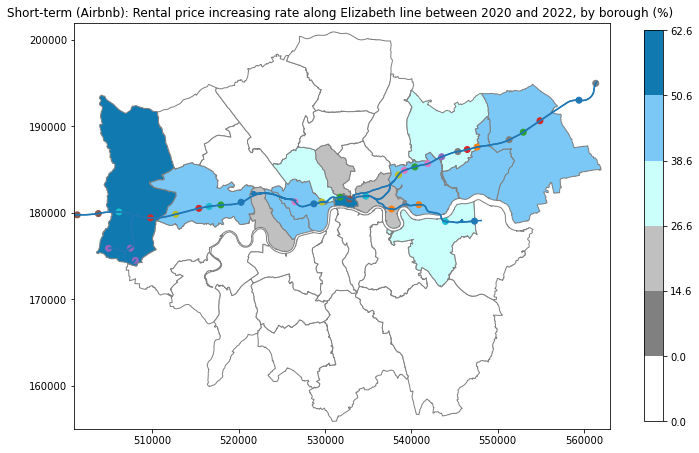

In [42]:
# Airbnb increasing rate plot

fig, ax = plt.subplots(1,1, figsize=(12,9))

# create discrete colormap
# https://xkcd.com/color/rgb/ very light pink
cmap = colors.ListedColormap(['white','grey','silver','xkcd:light light blue','xkcd:lightblue','xkcd:nice blue'])
bounds = [0,0.0001,14.6,26.6,38.6,50.6,62.6]
norm = colors.BoundaryNorm(bounds, cmap.N)


airbnb_merge.plot(ax=ax,figsize=(12,8), marker='*', markersize=0.25,  
         column='increase_rate_airbnb',cmap=cmap, legend=True, norm=norm,edgecolor='grey',legend_kwds={'shrink': 0.8})
         
stations.plot(ax=ax, column='STATION_NA')
track.plot(ax=ax)
ax.set_title("Short-term (Airbnb): Rental price increasing rate along Elizabeth line between 2020 and 2022, by borough (%) ")


# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

plt.savefig("Airbnb.png", bbox_inches = 'tight') 

### 4.2 Long-term 

In [43]:
# Combining price and borough
# Mark the value of the area that the Elizabethan line does not pass through as 0
longterm_merge=pd.merge(borough, longterm_choose, on='NAME',how='left')
longterm_merge=longterm_merge.replace(np.nan,0)
longterm_merge

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,code,median_2020,median_2022,increase_rate_longterm
0,Kingston upon Thames,E09000021,3726.117,0.000,F,0,0,"POLYGON ((516401.600 160201.800, 516407.300 16...",0,0.0,0.0,0.000000
1,Croydon,E09000008,8649.441,0.000,F,0,0,"POLYGON ((535009.200 159504.700, 535005.500 15...",0,0.0,0.0,0.000000
2,Bromley,E09000006,15013.487,0.000,F,0,0,"POLYGON ((540373.600 157530.400, 540361.200 15...",0,0.0,0.0,0.000000
3,Hounslow,E09000018,5658.541,60.755,F,0,0,"POLYGON ((521975.800 178100.000, 521967.700 17...",0,0.0,0.0,0.000000
4,Ealing,E09000009,5554.428,0.000,F,0,0,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,1458.0,1448.0,-0.685871
5,Havering,E09000016,11445.735,210.763,F,0,0,"POLYGON ((549893.900 181459.800, 549894.600 18...",E09000016,1051.0,1127.0,7.231208
6,Hillingdon,E09000017,11570.063,0.000,F,0,0,"POLYGON ((510599.800 191689.500, 510615.200 19...",E09000017,1147.0,1165.0,1.569311
7,Harrow,E09000015,5046.330,0.000,F,0,0,"POLYGON ((510599.800 191689.500, 510660.000 19...",0,0.0,0.0,0.000000
8,Brent,E09000005,4323.270,0.000,F,0,0,"POLYGON ((525201.000 182512.600, 525181.500 18...",0,0.0,0.0,0.000000
9,Barnet,E09000003,8674.837,0.000,F,0,0,"POLYGON ((524579.900 198355.200, 524594.300 19...",0,0.0,0.0,0.000000


Global increasing rate of long-term rental price between 2020 and 2022 is 4.1%. 

In the plot, the blue colours indicate a higher increasing rate than global and the grey colours indicates a lower increasing rate than global.

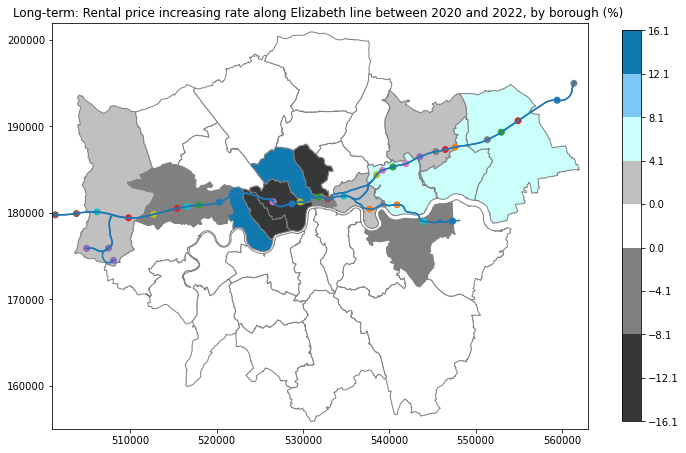

In [44]:
# Long-term increasing rate

fig, ax = plt.subplots(1,1, figsize=(12,9))

# create discrete colormap
cmap = colors.ListedColormap(['xkcd:dark grey','xkcd:dark grey','grey','grey','white','silver','xkcd:light light blue','xkcd:lightblue','xkcd:nice blue'])
bounds = [-16.1,-12.1,-8.1,-4.1,0,0.000001,4.1,8.1,12.1,16.1]
norm = colors.BoundaryNorm(bounds, cmap.N)

longterm_merge.plot(ax=ax,figsize=(12,8), marker='*', markersize=0.25,  
         column='increase_rate_longterm',legend=True,cmap=cmap, norm=norm,edgecolor='grey',legend_kwds={'shrink': 0.8})
         
stations.plot(ax=ax, column='STATION_NA')
track.plot(ax=ax)
ax.set_title("Long-term: Rental price increasing rate along Elizabeth line between 2020 and 2022, by borough (%) ")


# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

plt.savefig("Long-term.png", bbox_inches = 'tight') 

In [45]:
# Wd end

## 5. Description analysis 
Check whether the airbnb hosts used the term 'Elizabeth line' for advertisement in 2020 and 2022 

In [46]:
# copy the raw data
airbnb_22 = airbnb_22_raw.copy()

In [47]:
# Check the column data type
airbnb_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            69351 non-null  int64  
 1   listing_url                                   69351 non-null  object 
 2   scrape_id                                     69351 non-null  int64  
 3   last_scraped                                  69351 non-null  object 
 4   source                                        69351 non-null  object 
 5   name                                          69330 non-null  object 
 6   description                                   67832 non-null  object 
 7   neighborhood_overview                         39964 non-null  object 
 8   picture_url                                   69351 non-null  object 
 9   host_id                                       69351 non-null 

In [48]:
# Drop all rows where the description is NaN:
airbnb_22 = airbnb_22.dropna(subset=['description'])

In [49]:
# Find the columns with 'Elizabeth line' in 2022 and ignore the case
# Create the dataframe with Elizabeth line description
el22 = airbnb_22[
    airbnb_22.description.str.contains(r'Elizabeth line', regex=True, flags=re.IGNORECASE)
].description
el22

690      The property is a Victorian cottage with 2 bed...
1601     Our spacious, light and quiet apartment combin...
1638     Our house is 30 minutes away central London gr...
1793     BOOK A HOUSE - GET A HOME<br /><br />You will ...
3332     Enjoy all the best that East London has to off...
                               ...                        
68581    This 3 bedrooms flat in the residential area o...
68586    Your family will be close to everything when y...
69265    With views of the Thames river in every window...
69274    Located on the 1st floor of the building, kick...
69305    A lovely, cosy double room in a spacious apart...
Name: description, Length: 270, dtype: object

In [50]:
print(f'The number of houses with the Elizabeth line description in 2022 is {len(el22)}')

The number of houses with the Elizabeth line description in 2022 is 270


In [51]:
# Do the same process to load and check the data from 2020
airbnb_20 = airbnb_20_raw.copy()

In [52]:
# Drop all rows where the description is NaN:
airbnb_20 = airbnb_20.dropna(subset=['description'])

In [53]:
# Find the columns with 'Elizabeth line' in 2020 and ignore the case
# Create the dataframe with Elizabeth line description
el20 = airbnb_20[
    airbnb_20.description.str.contains(r'Elizabeth line', regex=True, flags=re.IGNORECASE)
].description
el20

2398     ASK - Our spacious, light and quiet apartment ...
20028    This two bedroom penthouse apartment is locate...
20029    This one bedroom apartment is located on the f...
20030    This one bedroom apartment is located on the f...
35279    This spacious 2 Bedroom apartment is on buzzin...
35330    This spacious 2 Bedroom apartment is on buzzin...
35399    This spacious 2 Bedroom apartment is on buzzin...
37634    I defined my place as the happiness in ones li...
41645    Bright and airy, newly refurbished and fully e...
49264    My spacious, light and quiet apartment is set ...
56050    The unique Manhattan loft style apartment is l...
61954    This double room in a semi-detached house arra...
61960    This double room in a semi-detached house arra...
71014    Modern Mansionnate recently refurbished with q...
Name: description, dtype: object

In [54]:
print(f'The number of houses with the Elizabeth line description in 2020 is {len(el20)}')

The number of houses with the Elizabeth line description in 2020 is 14


In [55]:
# Expand the row width to view the discription
pd.set_option('max_colwidth',1500)

In [56]:
el20

2398     ASK - Our spacious, light and quiet apartment combines the best charm of London: the juxtaposition of old and new.  Located in the gated Heritage Quarter which forms the heart of the Royal Arsenal, with a Thames River view, it offers contemporary comfort with period features, WIFI and easy transport to all London destinations by Thames Clipper, Train & DLR/Tube. (High Speed Elizabeth Line Opening 2020 with direct journey to Oxford Street - Heathrow).  Perfect for London City Airport, Excel & O2.<br /><br /><b>The space</b><br />Be a part of history & stay in a home that has consistently been ranked as one of AirBnb's & HomeAway's very best London properties...A welcome respite after a day sight-seeing or working in London, come 'home' to this unique and spacious (over a thousand sq. ft.), window-filled, apartment with many original architectural features set within the exclusive, gated, heritage area of the prestigious, award-winning Royal Arsenal Riverside. This split-level, 

## 6. Radius analysis for airbnb listing prices 

In [57]:
# Ad

### Reading the Airbnb data 

In [148]:
air_2020 = airbnb_2020.copy()
print(f"Data frame is {air_2020.shape[0]:,} x {air_2020.shape[1]}")

Data frame is 74,184 x 74


In [149]:
air_2022 = airbnb_2022.copy()
print(f"Data frame is {air_2020.shape[0]:,} x {air_2020.shape[1]}")

Data frame is 74,184 x 74


### Subsetting the listings data 

#### Distance to station 

In [150]:
# Creating a distance to station column in each dataset
# Read the geodataframes
geo_air_2020 = gpd.GeoDataFrame(air_2020, geometry=gpd.points_from_xy(air_2020.longitude, air_2020.latitude), crs="EPSG:4326")
geo_air_2022 = gpd.GeoDataFrame(air_2022, geometry=gpd.points_from_xy(air_2022.longitude, air_2022.latitude), crs="EPSG:4326")

In [151]:
# Changing CRS
geo_air_2020.to_crs(crs="EPSG:27700",inplace=True)
geo_air_2022.to_crs(crs="EPSG:27700",inplace=True)

In [152]:
geo_air_2020['dist_to_s'] = geo_air_2020.geometry.apply(lambda x: stations.distance(x).min())
geo_air_2022['dist_to_s'] = geo_air_2022.geometry.apply(lambda x: stations.distance(x).min())

In [153]:
# 2020 
# Inspecting
geo_air_2020['dist_to_s'].head()

0    6001.639654
1    5387.019564
2    3198.559619
3     927.498223
4    4319.582856
Name: dist_to_s, dtype: float64

In [154]:
# Descriptive statistics
geo_air_2020['dist_to_s'].describe()

count    74184.000000
mean      3839.780589
std       3257.197047
min          5.757387
25%       1467.727222
50%       2899.150563
75%       5078.073807
max      24049.824765
Name: dist_to_s, dtype: float64

In [155]:
# Number of listing in the radius
geo_air_2020[geo_air_2020.dist_to_s<1000].shape

(11784, 76)

In [156]:
# Median price
geo_air_2020[geo_air_2020.dist_to_s<1000].price.median()

99.0

<AxesSubplot:>

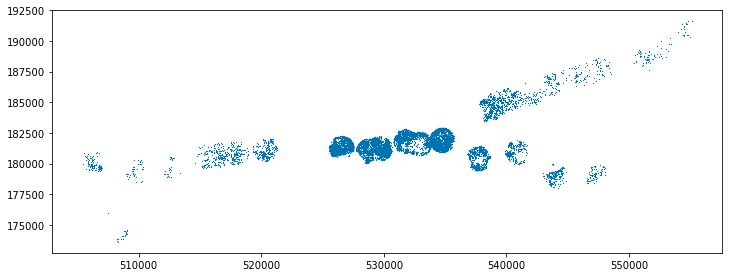

In [157]:
# Ploting geometry
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2020[geo_air_2020.dist_to_s<1000].plot(ax=ax,marker='*',markersize=0.1)

In [158]:
# Number of listing in the radius
geo_air_2020[geo_air_2020.dist_to_s<2000].shape

(25349, 76)

In [159]:
# Median price
geo_air_2020[geo_air_2020.dist_to_s<2000].price.describe()

count    25349.000000
mean       135.749543
std        339.303009
min          0.000000
25%         50.000000
50%         90.000000
75%        149.000000
max      18638.000000
Name: price, dtype: float64

<AxesSubplot:>

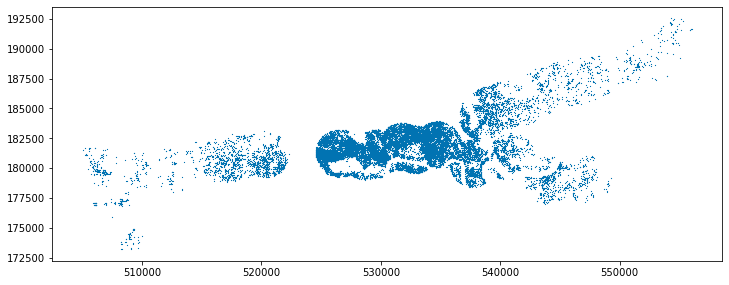

In [160]:
# Ploting geometry
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2020[geo_air_2020.dist_to_s<2000].plot(ax=ax,marker='*',markersize=0.1)

In [161]:
# Number of listings
geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].shape

(13565, 76)

In [162]:
# Descriptive statistics
geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].price.describe()

count    13565.000000
mean       118.675418
std        243.013436
min          0.000000
25%         46.000000
50%         82.000000
75%        130.000000
max      18638.000000
Name: price, dtype: float64

<AxesSubplot:>

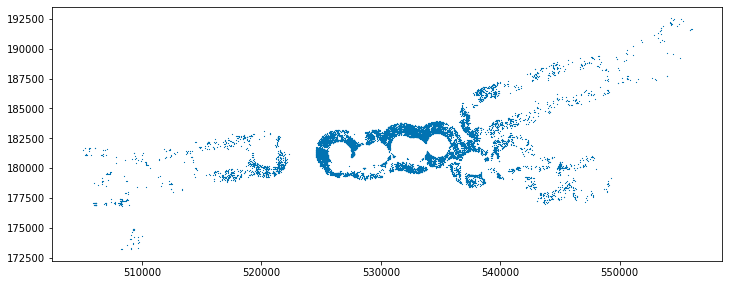

In [163]:
# Ploting geometry
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].plot(ax=ax,marker='*',markersize=0.1)

In [164]:
# 2022
geo_air_2022['dist_to_s'].head()

0    5464.913940
1    3227.728687
2    1380.203430
3    1019.550642
4     927.498223
Name: dist_to_s, dtype: float64

In [165]:
geo_air_2022['dist_to_s'].describe()

count    69351.000000
mean      3966.567559
std       3412.100956
min          3.190962
25%       1501.836171
50%       2962.861925
75%       5282.176950
max      26310.008788
Name: dist_to_s, dtype: float64

In [166]:
geo_air_2022[geo_air_2022.dist_to_s<1000].shape

(10825, 77)

In [167]:
geo_air_2022[geo_air_2022.dist_to_s<1000].price.median()

140.0

<AxesSubplot:>

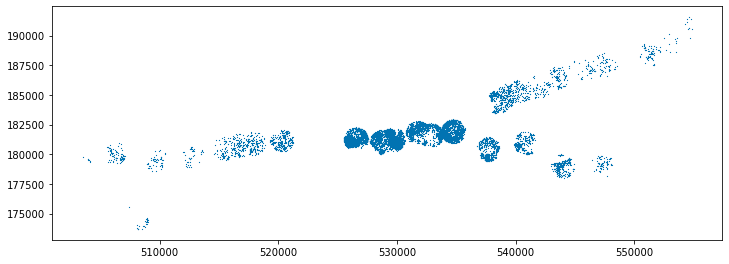

In [168]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2022[geo_air_2022.dist_to_s<1000].plot(ax=ax,marker='*',markersize=0.1)

In [169]:
geo_air_2022[geo_air_2022.dist_to_s<2000].shape

(23222, 77)

In [170]:
geo_air_2022[geo_air_2022.dist_to_s<2000].price.describe()

count    23222.000000
mean       203.761132
std        433.981703
min          0.000000
25%         65.000000
50%        120.000000
75%        215.000000
max      25000.000000
Name: price, dtype: float64

<AxesSubplot:>

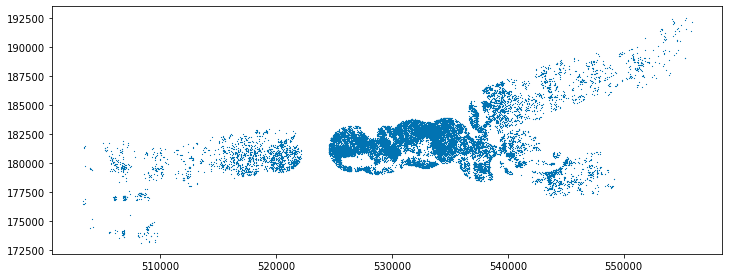

In [171]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2022[geo_air_2022.dist_to_s<2000].plot(ax=ax,marker='*',markersize=0.1)

In [172]:
geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].shape

(12397, 77)

In [173]:
geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].price.describe()

count    12397.000000
mean       184.169073
std        342.960227
min          0.000000
25%         60.000000
50%        103.000000
75%        189.000000
max       9999.000000
Name: price, dtype: float64

<AxesSubplot:>

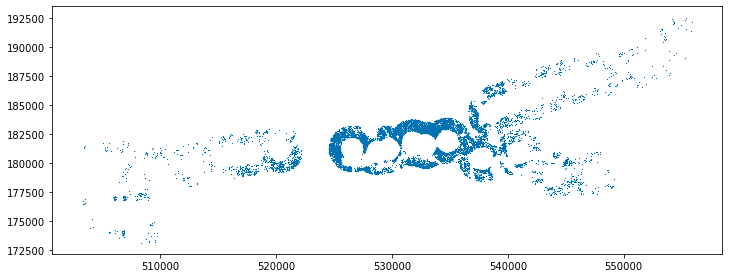

In [174]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].plot(ax=ax,marker='*',markersize=0.1)

### Overall results

In [175]:
print(f"2020 Airbnb listings \n1 km radious\nNumber of listings: {geo_air_2020[geo_air_2020.dist_to_s<1000].shape[0]:,}\nMedian price: {geo_air_2020[geo_air_2020.dist_to_s<1000]['price'].median()}.")

2020 Airbnb listings 
1 km radious
Number of listings: 11,784
Median price: 99.0.


In [176]:
print(f"2020 Airbnb listings \n1-2 km radious\nNumber of listings: {geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].shape[0]:,}\nMedian price: {geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)]['price'].median()}.")

2020 Airbnb listings 
1-2 km radious
Number of listings: 13,565
Median price: 82.0.


In [177]:
print(f"2020 Airbnb listings \n2 km radious\nNumber of listings: {geo_air_2020[geo_air_2020.dist_to_s<2000].shape[0]:,}\nMedian price: {geo_air_2020[geo_air_2020.dist_to_s<2000]['price'].median()}.")

2020 Airbnb listings 
2 km radious
Number of listings: 25,349
Median price: 90.0.


In [178]:
print(f"2022 Airbnb listings \n1 km radious\nNumber of listings: {geo_air_2022[geo_air_2022.dist_to_s<1000].shape[0]:,}\nMedian price: {geo_air_2022[geo_air_2022.dist_to_s<1000]['price'].median()}.\nMedian price variation: {(geo_air_2022[geo_air_2022.dist_to_s<1000]['price'].median()-geo_air_2020[geo_air_2020.dist_to_s<1000]['price'].median())/geo_air_2020[geo_air_2020.dist_to_s<1000]['price'].median():,.2%}.")

2022 Airbnb listings 
1 km radious
Number of listings: 10,825
Median price: 140.0.
Median price variation: 41.41%.


In [179]:
print(f"2022 Airbnb listings \n1-2 km radious\nNumber of listings: {geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].shape[0]:,}\nMedian price: {geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)]['price'].median()}\nMedian price variation: {(geo_air_2022[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)]['price'].median()-geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)]['price'].median())/geo_air_2020[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)]['price'].median():,.2%}.")

2022 Airbnb listings 
1-2 km radious
Number of listings: 12,397
Median price: 103.0
Median price variation: 25.61%.


In [180]:
print(f"2022 Airbnb listings \n2 km radious\nNumber of listings: {geo_air_2022[geo_air_2022.dist_to_s<2000].shape[0]:,}\nMedian price: {geo_air_2022[geo_air_2022.dist_to_s<2000]['price'].median()}\nMedian price variation: {(geo_air_2022[geo_air_2022.dist_to_s<2000]['price'].median()-geo_air_2020[geo_air_2020.dist_to_s<2000]['price'].median())/geo_air_2020[geo_air_2020.dist_to_s<2000]['price'].median():,.2%} .")

2022 Airbnb listings 
2 km radious
Number of listings: 23,222
Median price: 120.0
Median price variation: 33.33% .


### Spatial joining (Stations name) 

In [181]:
geo_air_2020_js = geo_air_2020.sjoin_nearest(stations,how='inner',distance_col='dist_join')
geo_air_2022_js = geo_air_2022.sjoin_nearest(stations,how='inner',distance_col='dist_join')

In [182]:
# 2020
geo_air_2020_js.shape

(74184, 82)

In [183]:
geo_air_2020_js[geo_air_2020_js.dist_to_s<2000].shape

(25349, 82)

In [184]:
geo_air_2020_js.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,dist_to_s,index_right,OBJECTID,STATION_NA,SIZE_,SE_ANNO_CA,dist_join
0,11551.0,https://www.airbnb.com/rooms/11551,20200824024753.0,2020-08-26,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039.0,https://www.airbnb.com/users/show/43039,...,0.0,1.51,POINT (530885.122 175377.940),6001.639654,17,18,Tottenham Court Road,Large,None,6001.639654
3,17402.0,https://www.airbnb.com/rooms/17402,20200824024753.0,2020-08-27,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564.0,https://www.airbnb.com/users/show/67564,...,0.0,0.37,POINT (529075.790 181974.865),927.498223,17,18,Tottenham Court Road,Large,None,927.498223
35,47192.0,https://www.airbnb.com/rooms/47192,20200824024753.0,2020-08-26,Single Room in zone 1,"Hi everyone, welcome to my little haven. My fl...",The nearest tube station to my flat is Great P...,https://a0.muscache.com/pictures/54290798/f46d...,212734.0,https://www.airbnb.com/users/show/212734,...,0.0,3.09,POINT (528852.745 182831.588),1772.264940,17,18,Tottenham Court Road,Large,None,1772.264940
51,65908.0,https://www.airbnb.com/rooms/65908,20200824024753.0,2020-08-26,Lovely room in cool Brixton,<b>The space</b><br />Available for you to ren...,NaN,https://a0.muscache.com/pictures/4350503/e0262...,322341.0,https://www.airbnb.com/users/show/322341,...,0.0,NaN,POINT (530700.653 175090.560),6249.809664,17,18,Tottenham Court Road,Large,None,6249.809664
58,71875.0,https://www.airbnb.com/rooms/71875,20200824024753.0,2020-08-26,"Bright Very Central 1-Bed in W1. King Bed, Wifi",Clean modern well-equipped apt in very central...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/26416186/d382...,67564.0,https://www.airbnb.com/users/show/67564,...,0.0,0.70,POINT (529238.223 182002.362),859.072886,17,18,Tottenham Court Road,Large,None,859.072886


In [185]:
geo_air_2020_js.STATION_NA.unique()

array(['Tottenham Court Road', 'Farringdon', 'Paddington', 'Hanwell',
       'Ealing Broadway', 'Whitechapel', 'Canary Wharf',
       'Acton Main Line', 'Liverpool Street', 'Maryland', 'Bond Street',
       'Ilford', 'Forest Gate', 'Heathrow T4', 'Romford', 'Woolwich',
       'Stratford', 'Southall', 'Manor Park', 'Custom House',
       'West Ealing', 'Hayes & Harlington', 'Chadwell Heath',
       'West Drayton', 'Abbey Wood', 'Seven Kings', 'Harold Wood',
       'Goodmayes', 'Gidea Park', 'Heathrow Central', 'Heathrow T5'],
      dtype=object)

In [186]:
# 2022
geo_air_2022_js.shape

(69351, 83)

In [187]:
geo_air_2022_js[geo_air_2022_js.dist_to_s<2000].shape

(23222, 83)

In [188]:
geo_air_2022_js.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,dist_to_s,index_right,OBJECTID,STATION_NA,SIZE_,SE_ANNO_CA,dist_join
0,13913,https://www.airbnb.com/rooms/13913,20220910194334,2022-09-11,city scrape,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,0,0.20,POINT (530901.013 187213.787),5464.913940,19,20,Farringdon,Large,None,5464.913940
5,107048,https://www.airbnb.com/rooms/107048,20220910194334,2022-09-11,city scrape,A Luxury Studio Suite in Clerkenwell,"Situated in the heart of vibrant Clerkenwell, ...",Clerkenwell & Vicinity Recommendations<br /><b...,https://a0.muscache.com/pictures/ff065257-7660...,259088,...,0,3.59,POINT (531572.006 182353.814),569.496622,19,20,Farringdon,Large,None,569.496622
10,116268,https://www.airbnb.com/rooms/116268,20220910194334,2022-09-11,city scrape,DOUBLE ROOM NEAR CENTRAL LONDON,<b>The space</b><br />One lovely double bedroo...,NaN,https://a0.muscache.com/pictures/855414/0f978d...,586671,...,0,0.29,POINT (530350.368 191957.865),10238.504293,19,20,Farringdon,Large,None,10238.504293
32,38950,https://www.airbnb.com/rooms/38950,20220910194334,2022-09-11,previous scrape,Room 1 Large Double Bedroom - front ground floor,Room 1 <br />Bright and Spacious Double Bedro...,"North London, West Green, Tottenham",https://a0.muscache.com/pictures/ab0c51a0-adc9...,167107,...,0,0.11,POINT (532676.137 189288.550),7526.886587,19,20,Farringdon,Large,None,7526.886587
37,40228,https://www.airbnb.com/rooms/40228,20220910194334,2022-09-11,previous scrape,Room 4 Cosy Double Bedroom on First Floor,Double Bedroom First Floor with double bed<br...,"West Green is an area of North London, England...",https://a0.muscache.com/pictures/82ed75e5-cfb1...,167107,...,0,NaN,POINT (532563.728 189345.700),7570.903745,19,20,Farringdon,Large,None,7570.903745


In [189]:
geo_air_2022_js.STATION_NA.unique()

array(['Farringdon', 'Paddington', 'Whitechapel', 'Tottenham Court Road',
       'Bond Street', 'Hanwell', 'Acton Main Line', 'Southall',
       'Custom House', 'Forest Gate', 'Stratford', 'Ealing Broadway',
       'Liverpool Street', 'Canary Wharf', 'Maryland', 'Chadwell Heath',
       'West Drayton', 'Abbey Wood', 'Ilford', 'Heathrow T4', 'Romford',
       'Woolwich', 'Manor Park', 'West Ealing', 'Seven Kings',
       'Hayes & Harlington', 'Harold Wood', 'Goodmayes', 'Gidea Park',
       'Heathrow Central', 'Heathrow T5', 'Brentwood', 'Iver'],
      dtype=object)

### Median price results by stations

Add the point of the station

In [190]:
# 2020
# Median price grouping by stations in 1 km radius
result_2020_r_1k = geo_air_2020_js[geo_air_2020_js.dist_to_s<1000].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2020_r_1k.head()

STATION_NA
Bond Street             206.0
Tottenham Court Road    146.0
Harold Wood             117.0
Farringdon              115.0
Paddington              114.0
Name: price, dtype: float64

In [191]:
# Median price grouping by stations in 2 km radius
result_2020_r_2k = geo_air_2020_js[geo_air_2020_js.dist_to_s<2000].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2020_r_2k.head()

STATION_NA
Bond Street             186.0
Tottenham Court Road    125.0
Paddington              110.0
Farringdon              100.0
Liverpool Street        100.0
Name: price, dtype: float64

In [192]:
# Median price grouping by stations in 1-2 km radius
result_2020_r_1k_2k = geo_air_2020_js[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2020_r_1k_2k.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


STATION_NA
Bond Street             145.0
Paddington              109.0
Liverpool Street         98.0
Farringdon               92.0
Tottenham Court Road     90.0
Name: price, dtype: float64

In [193]:
# 2022
# Median price grouping by stations in 1 km radius
result_2022_r_1k = geo_air_2022_js[geo_air_2022_js.dist_to_s<1000].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2022_r_1k.head()

STATION_NA
Bond Street             320.0
Tottenham Court Road    240.0
Harold Wood             172.5
Iver                    171.0
Liverpool Street        163.0
Name: price, dtype: float64

In [194]:
# Median price grouping by stations in 2 km radius
result_2022_r_2k = geo_air_2022_js[geo_air_2022_js.dist_to_s<2000].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2022_r_2k.head()

STATION_NA
Bond Street             288.0
Tottenham Court Road    192.0
Iver                    154.5
Paddington              150.0
Harold Wood             145.0
Name: price, dtype: float64

In [195]:
# Median price grouping by stations in 1-2 km radius
result_2022_r_1k_2k = geo_air_2022_js[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].groupby('STATION_NA')['price'].agg('median').sort_values(ascending = False)
result_2022_r_1k_2k.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


STATION_NA
Bond Street         242.0
Paddington          150.0
Liverpool Street    134.0
Heathrow T4         125.0
Farringdon          125.0
Name: price, dtype: float64

#### Merging 2020 results 

In [196]:
# Mergins 1km with 1-2km radius by station
results_2020 = pd.merge(result_2020_r_1k, result_2020_r_1k_2k, right_index = True, left_index = True)
results_2020

,price_x,price_y
STATION_NA,,
Bond Street,206.0,145.0
Tottenham Court Road,146.0,90.0
Harold Wood,117.0,40.0
Farringdon,115.0,92.0
Paddington,114.0,109.0
Liverpool Street,104.5,98.0
Canary Wharf,80.0,60.0
Custom House,80.0,75.0
Stratford,75.0,55.0


In [197]:
# Renaming merged columns
results_2020.rename(columns={'price_x': 'R_1K_2020', 'price_y': 'R_1K_2K_2020'}, inplace=True)
results_2020

,R_1K_2020,R_1K_2K_2020
STATION_NA,,
Bond Street,206.0,145.0
Tottenham Court Road,146.0,90.0
Harold Wood,117.0,40.0
Farringdon,115.0,92.0
Paddington,114.0,109.0
Liverpool Street,104.5,98.0
Canary Wharf,80.0,60.0
Custom House,80.0,75.0
Stratford,75.0,55.0


In [198]:
# Mergins previous results with 2 km radius by station
results_2020_total = pd.merge(results_2020, result_2020_r_2k, right_index = True, left_index = True)
results_2020_total

,R_1K_2020,R_1K_2K_2020,price
STATION_NA,,,
Bond Street,206.0,145.0,186.0
Tottenham Court Road,146.0,90.0,125.0
Harold Wood,117.0,40.0,49.5
Farringdon,115.0,92.0,100.0
Paddington,114.0,109.0,110.0
Liverpool Street,104.5,98.0,100.0
Canary Wharf,80.0,60.0,68.0
Custom House,80.0,75.0,75.0
Stratford,75.0,55.0,60.0


In [199]:
# Renaming 2km radius column
results_2020_total.rename(columns={'price': 'R_2K_2020'}, inplace=True)
results_2020_total

,R_1K_2020,R_1K_2K_2020,R_2K_2020
STATION_NA,,,
Bond Street,206.0,145.0,186.0
Tottenham Court Road,146.0,90.0,125.0
Harold Wood,117.0,40.0,49.5
Farringdon,115.0,92.0,100.0
Paddington,114.0,109.0,110.0
Liverpool Street,104.5,98.0,100.0
Canary Wharf,80.0,60.0,68.0
Custom House,80.0,75.0,75.0
Stratford,75.0,55.0,60.0


#### Merging 2022 results

In [200]:
# Mergins 1km with 1-2km radius by station
results_2022 = pd.merge(result_2022_r_1k, result_2022_r_1k_2k, right_index = True, left_index = True)
results_2022

,price_x,price_y
STATION_NA,,
Bond Street,320.0,242.0
Tottenham Court Road,240.0,125.0
Harold Wood,172.5,80.0
Iver,171.0,46.0
Liverpool Street,163.0,134.0
Paddington,154.0,150.0
Farringdon,147.0,125.0
Canary Wharf,120.0,75.0
Custom House,120.0,99.5


In [201]:
# Renaming merged columns
results_2022.rename(columns={'price_x': 'R_1K_2022', 'price_y': 'R_1K_2K_2022'}, inplace=True)
results_2022

,R_1K_2022,R_1K_2K_2022
STATION_NA,,
Bond Street,320.0,242.0
Tottenham Court Road,240.0,125.0
Harold Wood,172.5,80.0
Iver,171.0,46.0
Liverpool Street,163.0,134.0
Paddington,154.0,150.0
Farringdon,147.0,125.0
Canary Wharf,120.0,75.0
Custom House,120.0,99.5


In [202]:
# Mergins previous results with 2 km radius by station
results_2022_total = pd.merge(results_2022, result_2022_r_2k, right_index = True, left_index = True)
results_2022_total

,R_1K_2022,R_1K_2K_2022,price
STATION_NA,,,
Bond Street,320.0,242.0,288.0
Tottenham Court Road,240.0,125.0,192.0
Harold Wood,172.5,80.0,145.0
Iver,171.0,46.0,154.5
Liverpool Street,163.0,134.0,140.0
Paddington,154.0,150.0,150.0
Farringdon,147.0,125.0,134.0
Canary Wharf,120.0,75.0,85.0
Custom House,120.0,99.5,105.0


In [203]:
# Renaming 2km column
results_2022_total.rename(columns={'price': 'R_2K_2022'}, inplace=True)
results_2022_total

,R_1K_2022,R_1K_2K_2022,R_2K_2022
STATION_NA,,,
Bond Street,320.0,242.0,288.0
Tottenham Court Road,240.0,125.0,192.0
Harold Wood,172.5,80.0,145.0
Iver,171.0,46.0,154.5
Liverpool Street,163.0,134.0,140.0
Paddington,154.0,150.0,150.0
Farringdon,147.0,125.0,134.0
Canary Wharf,120.0,75.0,85.0
Custom House,120.0,99.5,105.0


#### Merging 2020 and 2022 results 

In [204]:
# Merging the 2020 and 2022 results by station
results_2020_2022_total = pd.merge(results_2020_total, results_2022_total, right_index = True, left_index = True)
results_2020_2022_total

,R_1K_2020,R_1K_2K_2020,R_2K_2020,R_1K_2022,R_1K_2K_2022,R_2K_2022
STATION_NA,,,,,,
Bond Street,206.0,145.0,186.0,320.0,242.0,288.0
Tottenham Court Road,146.0,90.0,125.0,240.0,125.0,192.0
Harold Wood,117.0,40.0,49.5,172.5,80.0,145.0
Farringdon,115.0,92.0,100.0,147.0,125.0,134.0
Paddington,114.0,109.0,110.0,154.0,150.0,150.0
Liverpool Street,104.5,98.0,100.0,163.0,134.0,140.0
Canary Wharf,80.0,60.0,68.0,120.0,75.0,85.0
Custom House,80.0,75.0,75.0,120.0,99.5,105.0
Stratford,75.0,55.0,60.0,97.0,80.0,85.0


In [205]:
# Calculating the percentage variations at each radius between 2020 and 2022
results_2020_2022_total['diff_1K'] = round((results_2020_2022_total['R_1K_2022']-results_2020_2022_total['R_1K_2020'])/results_2020_2022_total['R_1K_2020'],3)
results_2020_2022_total['diff_1K_2K'] = round((results_2020_2022_total['R_1K_2K_2022']-results_2020_2022_total['R_1K_2K_2020'])/results_2020_2022_total['R_1K_2K_2020'],3)
results_2020_2022_total['diff_2K'] = round((results_2020_2022_total['R_2K_2022']-results_2020_2022_total['R_2K_2020'])/results_2020_2022_total['R_2K_2020'],3)

# Assigning percentage format
results_2020_2022_total.style.format({
    'diff_1K': '{:,.2%}'.format,
    'diff_1K_2K': '{:,.2%}'.format,
    'diff_2K': '{:,.2%}'.format,
})

# Sorting by 1k radius difference
results_2020_2022_total.sort_values('diff_1K',ascending=False)

,R_1K_2020,R_1K_2K_2020,R_2K_2020,R_1K_2022,R_1K_2K_2022,R_2K_2022,diff_1K,diff_1K_2K,diff_2K
STATION_NA,,,,,,,,,
Hanwell,42.0,45.0,45.0,85.0,72.5,80.0,1.024,0.611,0.778
Goodmayes,35.0,50.0,45.5,67.0,48.0,60.0,0.914,-0.040,0.319
Southall,42.0,33.0,35.0,80.0,65.0,72.0,0.905,0.970,1.057
Hayes & Harlington,45.0,40.0,40.0,78.0,57.0,70.0,0.733,0.425,0.750
Heathrow Central,52.0,60.0,59.5,89.0,111.0,105.5,0.712,0.850,0.773
Tottenham Court Road,146.0,90.0,125.0,240.0,125.0,192.0,0.644,0.389,0.536
Ealing Broadway,57.0,46.0,50.0,90.0,78.0,86.0,0.579,0.696,0.720
Liverpool Street,104.5,98.0,100.0,163.0,134.0,140.0,0.560,0.367,0.400
Bond Street,206.0,145.0,186.0,320.0,242.0,288.0,0.553,0.669,0.548


#### Ploting results 

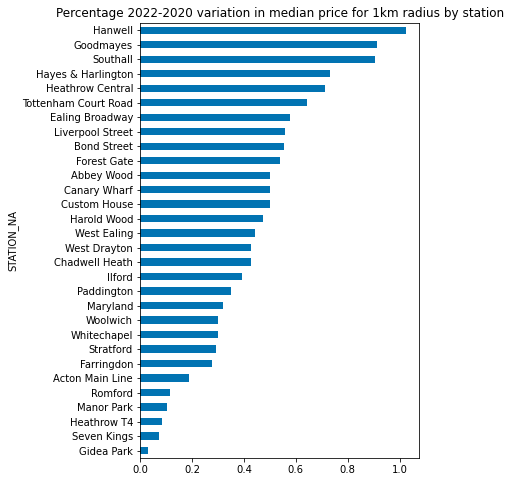

In [206]:
results_2020_2022_total['diff_1K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price for 1km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Price_median_var_1k.jpg",bbox_inches='tight',dpi=300)
plt.show()

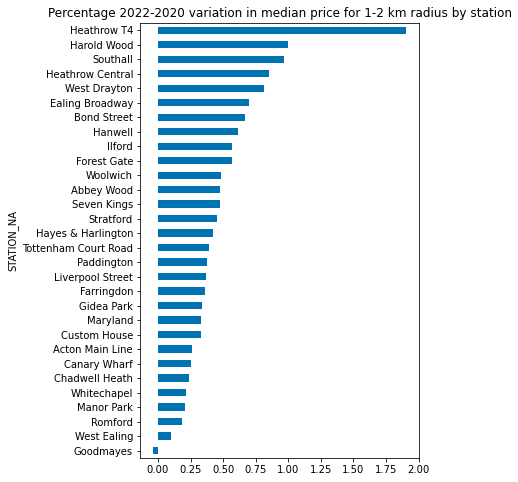

In [207]:
results_2020_2022_total['diff_1K_2K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price for 1-2 km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Price_median_var_1k_2k.jpg",bbox_inches='tight',dpi=300)
plt.show()

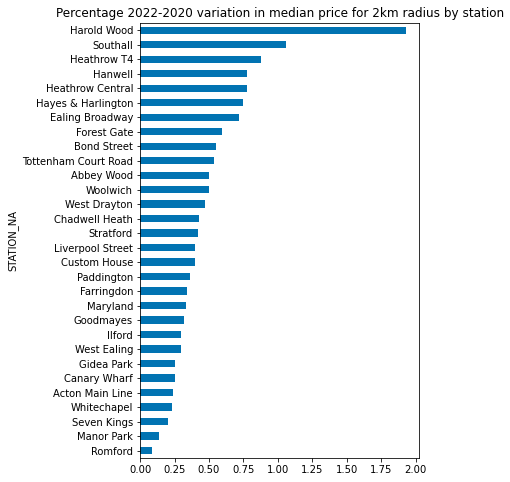

In [208]:
results_2020_2022_total['diff_2K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price for 2km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Price_median_var_2k.jpg",bbox_inches='tight',dpi=300)
plt.show()

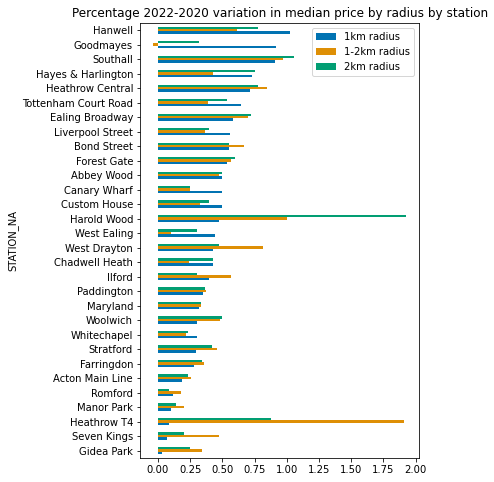

In [209]:
fig, ax = plt.subplots()
results_2020_2022_total[['diff_1K','diff_1K_2K','diff_2K']].sort_values('diff_1K',ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price by radius by station',figsize=(5,8),in_layout=True,ax=ax)
ax.legend(["1km radius", "1-2km radius","2km radius"])

### Number of listings results by stations 

In [210]:
# 2020
# Grouping count of listings in 1 km radius by stations
count_2020_r_1k = geo_air_2020_js[geo_air_2020_js.dist_to_s<1000].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2020_r_1k.head()

STATION_NA
Paddington              2127
Whitechapel             1973
Tottenham Court Road    1934
Farringdon               996
Bond Street              976
Name: id, dtype: int64

In [211]:
# Grouping count of listings in 2 km radius by stations
count_2020_r_2k = geo_air_2020_js[geo_air_2020_js.dist_to_s<2000].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2020_r_2k.head()

STATION_NA
Paddington              4877
Whitechapel             4202
Tottenham Court Road    2907
Farringdon              2426
Liverpool Street        2034
Name: id, dtype: int64

In [212]:
# Grouping count of listings in 1-2 km radius by stations
count_2020_r_1k_2k = geo_air_2020_js[(geo_air_2020.dist_to_s<2000) & (geo_air_2020.dist_to_s>1000)].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2020_r_1k_2k.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


STATION_NA
Paddington          2750
Whitechapel         2229
Farringdon          1430
Liverpool Street    1360
Canary Wharf        1095
Name: id, dtype: int64

In [213]:
# 2022
# Grouping count of listings in 1 km radius by stations
count_2022_r_1k = geo_air_2022_js[geo_air_2022_js.dist_to_s<1000].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2022_r_1k.head()

STATION_NA
Paddington              2192
Tottenham Court Road    1696
Whitechapel             1554
Bond Street              920
Farringdon               775
Name: id, dtype: int64

In [214]:
# Grouping count of listings in 2 km radius by stations
count_2022_r_2k = geo_air_2022_js[geo_air_2022_js.dist_to_s<2000].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2022_r_2k.head()

STATION_NA
Paddington              4503
Whitechapel             3490
Tottenham Court Road    2611
Farringdon              2133
Liverpool Street        1851
Name: id, dtype: int64

In [215]:
# Grouping count of listings in 1-2 km radius by stations
count_2022_r_1k_2k = geo_air_2022_js[(geo_air_2022.dist_to_s<2000) & (geo_air_2022.dist_to_s>1000)].groupby('STATION_NA')['id'].agg('count').sort_values(ascending = False)
count_2022_r_1k_2k.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


STATION_NA
Paddington          2311
Whitechapel         1936
Farringdon          1358
Liverpool Street    1213
Canary Wharf         989
Name: id, dtype: int64

#### Merging 2020 listings results

In [216]:
# Merging 1k with 1-2km count of listings
count_2020 = pd.merge(count_2020_r_1k, count_2020_r_1k_2k, right_index = True, left_index = True)
count_2020

,id_x,id_y
STATION_NA,,
Paddington,2127,2750
Whitechapel,1973,2229
Tottenham Court Road,1934,973
Farringdon,996,1430
Bond Street,976,548
Canary Wharf,707,1095
Liverpool Street,674,1360
Custom House,284,440
Stratford,257,642


In [217]:
# Renaming merged columns
count_2020.rename(columns={'id_x': 'R_1K_2020', 'id_y': 'R_1K_2K_2020'}, inplace=True)
count_2020

,R_1K_2020,R_1K_2K_2020
STATION_NA,,
Paddington,2127,2750
Whitechapel,1973,2229
Tottenham Court Road,1934,973
Farringdon,996,1430
Bond Street,976,548
Canary Wharf,707,1095
Liverpool Street,674,1360
Custom House,284,440
Stratford,257,642


In [218]:
# Merging previous results with 2km listings counts
count_2020_total = pd.merge(count_2020, count_2020_r_2k, right_index = True, left_index = True)
count_2020_total

,R_1K_2020,R_1K_2K_2020,id
STATION_NA,,,
Paddington,2127,2750,4877
Whitechapel,1973,2229,4202
Tottenham Court Road,1934,973,2907
Farringdon,996,1430,2426
Bond Street,976,548,1524
Canary Wharf,707,1095,1802
Liverpool Street,674,1360,2034
Custom House,284,440,724
Stratford,257,642,899


In [219]:
# Renaming 2km column
count_2020_total.rename(columns={'id': 'R_2K_2020'}, inplace=True)
count_2020_total

,R_1K_2020,R_1K_2K_2020,R_2K_2020
STATION_NA,,,
Paddington,2127,2750,4877
Whitechapel,1973,2229,4202
Tottenham Court Road,1934,973,2907
Farringdon,996,1430,2426
Bond Street,976,548,1524
Canary Wharf,707,1095,1802
Liverpool Street,674,1360,2034
Custom House,284,440,724
Stratford,257,642,899


#### Merging 2022 results

In [220]:
# Merging 1k with 1-2km count of listings
count_2022 = pd.merge(count_2022_r_1k, count_2022_r_1k_2k, right_index = True, left_index = True)
count_2022

,id_x,id_y
STATION_NA,,
Paddington,2192,2311
Tottenham Court Road,1696,915
Whitechapel,1554,1936
Bond Street,920,531
Farringdon,775,1358
Canary Wharf,638,989
Liverpool Street,638,1213
Custom House,287,442
Woolwich,266,267


In [221]:
# Renaming columns
count_2022.rename(columns={'id_x': 'R_1K_2022', 'id_y': 'R_1K_2K_2022'}, inplace=True)
count_2022

,R_1K_2022,R_1K_2K_2022
STATION_NA,,
Paddington,2192,2311
Tottenham Court Road,1696,915
Whitechapel,1554,1936
Bond Street,920,531
Farringdon,775,1358
Canary Wharf,638,989
Liverpool Street,638,1213
Custom House,287,442
Woolwich,266,267


In [222]:
# Merging previous results with 2km listings counts
count_2022_total = pd.merge(count_2022, count_2022_r_2k, right_index = True, left_index = True)
count_2022_total

,R_1K_2022,R_1K_2K_2022,id
STATION_NA,,,
Paddington,2192,2311,4503
Tottenham Court Road,1696,915,2611
Whitechapel,1554,1936,3490
Bond Street,920,531,1451
Farringdon,775,1358,2133
Canary Wharf,638,989,1627
Liverpool Street,638,1213,1851
Custom House,287,442,729
Woolwich,266,267,533


In [223]:
# Renaming 2km column
count_2022_total.rename(columns={'id': 'R_2K_2022'}, inplace=True)
count_2022_total

,R_1K_2022,R_1K_2K_2022,R_2K_2022
STATION_NA,,,
Paddington,2192,2311,4503
Tottenham Court Road,1696,915,2611
Whitechapel,1554,1936,3490
Bond Street,920,531,1451
Farringdon,775,1358,2133
Canary Wharf,638,989,1627
Liverpool Street,638,1213,1851
Custom House,287,442,729
Woolwich,266,267,533


#### Merging 2020 and 2022 listings results 

In [224]:
# Merging 2020 and 2022 count dfs
count_2020_2022_total = pd.merge(count_2020_total, count_2022_total, right_index = True, left_index = True)
count_2020_2022_total

,R_1K_2020,R_1K_2K_2020,R_2K_2020,R_1K_2022,R_1K_2K_2022,R_2K_2022
STATION_NA,,,,,,
Paddington,2127,2750,4877,2192,2311,4503
Whitechapel,1973,2229,4202,1554,1936,3490
Tottenham Court Road,1934,973,2907,1696,915,2611
Farringdon,996,1430,2426,775,1358,2133
Bond Street,976,548,1524,920,531,1451
Canary Wharf,707,1095,1802,638,989,1627
Liverpool Street,674,1360,2034,638,1213,1851
Custom House,284,440,724,287,442,729
Stratford,257,642,899,252,616,868


In [225]:
# Calculating percentage variation for each radius
count_2020_2022_total['diff_1K'] = (count_2020_2022_total['R_1K_2022']-count_2020_2022_total['R_1K_2020'])/count_2020_2022_total['R_1K_2020']
count_2020_2022_total['diff_1K_2K'] = (count_2020_2022_total['R_1K_2K_2022']-count_2020_2022_total['R_1K_2K_2020'])/count_2020_2022_total['R_1K_2K_2020']
count_2020_2022_total['diff_2K'] = (count_2020_2022_total['R_2K_2022']-count_2020_2022_total['R_2K_2020'])/count_2020_2022_total['R_2K_2020']

# Assigning percentage format
count_2020_2022_total.style.format({
    'diff_1K': '{:,.2%}'.format,
    'diff_1K_2K': '{:,.2%}'.format,
    'diff_2K': '{:,.2%}'.format,
})

count_2020_2022_total

,R_1K_2020,R_1K_2K_2020,R_2K_2020,R_1K_2022,R_1K_2K_2022,R_2K_2022,diff_1K,diff_1K_2K,diff_2K
STATION_NA,,,,,,,,,
Paddington,2127,2750,4877,2192,2311,4503,0.030559,-0.159636,-0.076686
Whitechapel,1973,2229,4202,1554,1936,3490,-0.212367,-0.131449,-0.169443
Tottenham Court Road,1934,973,2907,1696,915,2611,-0.123061,-0.059609,-0.101823
Farringdon,996,1430,2426,775,1358,2133,-0.221888,-0.050350,-0.120775
Bond Street,976,548,1524,920,531,1451,-0.057377,-0.031022,-0.047900
Canary Wharf,707,1095,1802,638,989,1627,-0.097595,-0.096804,-0.097114
Liverpool Street,674,1360,2034,638,1213,1851,-0.053412,-0.108088,-0.089971
Custom House,284,440,724,287,442,729,0.010563,0.004545,0.006906
Stratford,257,642,899,252,616,868,-0.019455,-0.040498,-0.034483


#### Ploting listings results

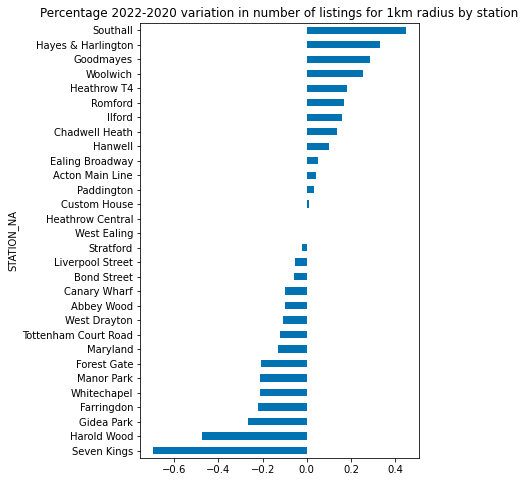

In [226]:
count_2020_2022_total['diff_1K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in number of listings for 1km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Listings_var_1k.jpg",bbox_inches='tight',dpi=300)
plt.show()

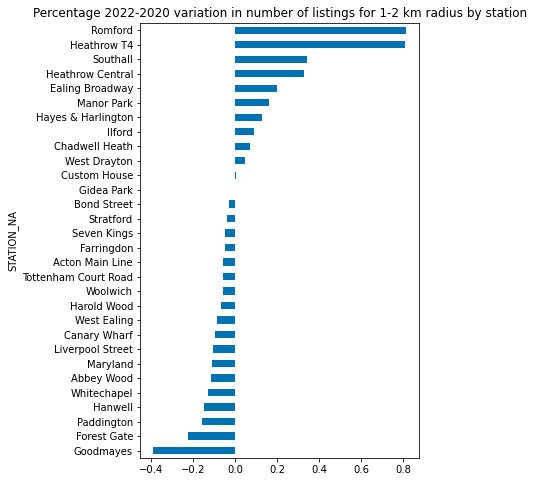

In [227]:
count_2020_2022_total['diff_1K_2K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in number of listings for 1-2 km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Listings_var_1k_2k.jpg",bbox_inches='tight',dpi=300)
plt.show()

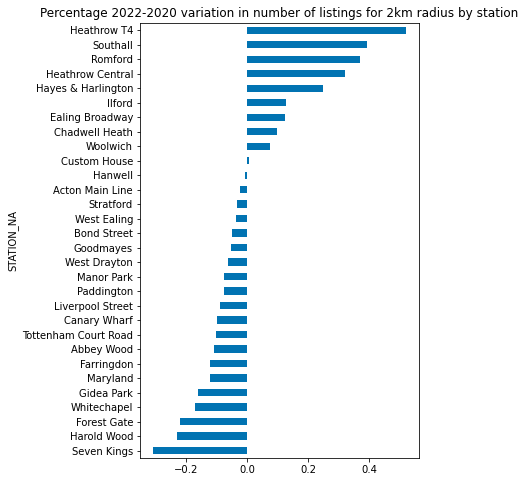

In [228]:
count_2020_2022_total['diff_2K'].sort_values(ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in number of listings for 2km radius by station',figsize=(5,8),in_layout=True)
plt.savefig("Listings_var_2k.jpg",bbox_inches='tight',dpi=300)
plt.show()

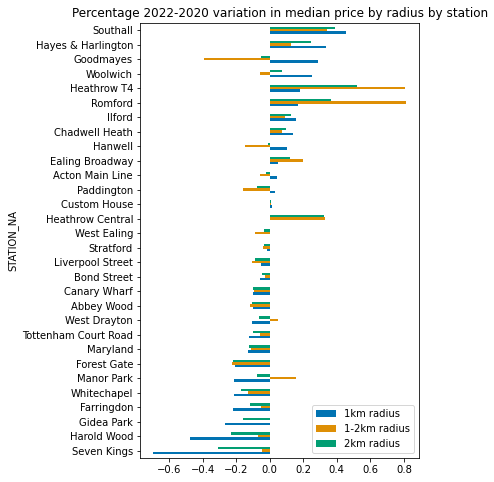

In [229]:
fig, ax = plt.subplots()
count_2020_2022_total[['diff_1K','diff_1K_2K','diff_2K']].sort_values('diff_1K',ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price by radius by station',figsize=(5,8),in_layout=True,ax=ax)
ax.legend(["1km radius", "1-2km radius","2km radius"])

### Final merge 

In [230]:
# Meging counts and median price df
final_2020_2022 = pd.merge(results_2020_2022_total, count_2020_2022_total, right_index = True, left_index = True, suffixes= ('_m','_c'))
final_2020_2022.sort_values('diff_1K_2K_m',ascending=False)

,R_1K_2020_m,R_1K_2K_2020_m,R_2K_2020_m,R_1K_2022_m,R_1K_2K_2022_m,R_2K_2022_m,diff_1K_m,diff_1K_2K_m,diff_2K_m,R_1K_2020_c,R_1K_2K_2020_c,R_2K_2020_c,R_1K_2022_c,R_1K_2K_2022_c,R_2K_2022_c,diff_1K_c,diff_1K_2K_c,diff_2K_c
STATION_NA,,,,,,,,,,,,,,,,,,
Heathrow T4,36.0,43.0,40.0,39.0,125.0,75.0,0.083,1.907,0.875,22,26,48,26,47,73,0.181818,0.807692,0.520833
Harold Wood,117.0,40.0,49.5,172.5,80.0,145.0,0.474,1.000,1.929,19,29,48,10,27,37,-0.473684,-0.068966,-0.229167
Southall,42.0,33.0,35.0,80.0,65.0,72.0,0.905,0.970,1.057,31,38,69,45,51,96,0.451613,0.342105,0.391304
Heathrow Central,52.0,60.0,59.5,89.0,111.0,105.5,0.712,0.850,0.773,1,55,56,1,73,74,0.000000,0.327273,0.321429
West Drayton,49.0,42.5,47.5,70.0,77.0,70.0,0.429,0.812,0.474,102,42,144,91,44,135,-0.107843,0.047619,-0.062500
Ealing Broadway,57.0,46.0,50.0,90.0,78.0,86.0,0.579,0.696,0.720,157,151,308,165,181,346,0.050955,0.198675,0.123377
Bond Street,206.0,145.0,186.0,320.0,242.0,288.0,0.553,0.669,0.548,976,548,1524,920,531,1451,-0.057377,-0.031022,-0.047900
Hanwell,42.0,45.0,45.0,85.0,72.5,80.0,1.024,0.611,0.778,70,54,124,77,46,123,0.100000,-0.148148,-0.008065
Ilford,61.0,35.0,50.0,85.0,55.0,65.0,0.393,0.571,0.300,88,68,156,102,74,176,0.159091,0.088235,0.128205


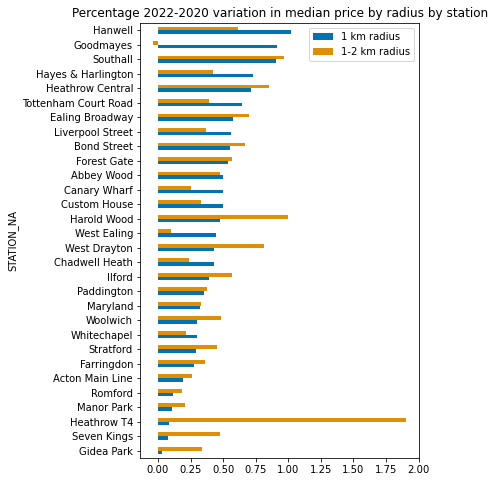

In [231]:
fig, ax = plt.subplots()
final_2020_2022[['diff_1K_m','diff_1K_2K_m']].sort_values('diff_1K_m',ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in median price by radius by station',figsize=(5,8),in_layout=True,ax=ax)
ax.legend(["1 km radius", "1-2 km radius"])
plt.savefig("Price_median_var_1k_1-2k.jpg",bbox_inches='tight',dpi=300)

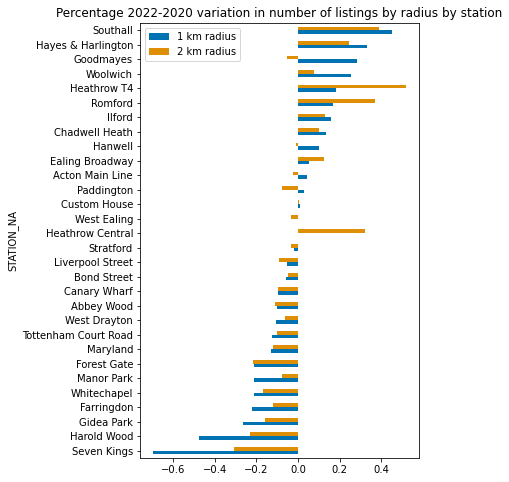

In [232]:
fig, ax = plt.subplots()
final_2020_2022[['diff_1K_c','diff_2K_c']].sort_values('diff_1K_c',ascending=True).plot(kind='barh',sort_columns=True, title='Percentage 2022-2020 variation in number of listings by radius by station',figsize=(5,8),in_layout=True,ax=ax)
ax.legend(["1 km radius", "2 km radius"])

In [233]:
# Ad end

## 7. Zone analysis for airbnb listing prices 

<AxesSubplot:>

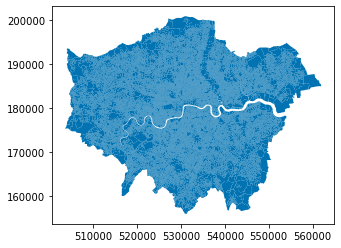

In [234]:
# Copy the raw data from London shape file
London = London_raw.copy()

# Change the CRS to EPSG 27700
London = London.to_crs('EPSG:27700')

# Plot the area
London.plot()

<AxesSubplot:>

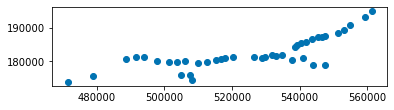

In [235]:
# Copy the raw data
el_station = el_station_raw.copy()

# Plot the shape
el_station.plot()

<AxesSubplot:>

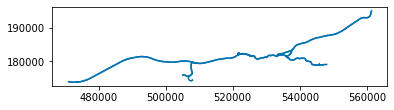

In [236]:
# Copy the raw data
el_track = el_track_raw.copy()

# Plot the shape
el_track.plot()

In [237]:
# Check the crs for these shape files
print(f'The crs for London OA: \n {London.crs}')
print(f'\n The crs for Elizabeth Line stations: \n {el_station.crs}')
print(f'\n The crs for Elizabeth Line tracks: \n {el_track.crs}')

The crs for London OA: 
 EPSG:27700

 The crs for Elizabeth Line stations: 
 epsg:27700

 The crs for Elizabeth Line tracks: 
 epsg:27700


<AxesSubplot:>

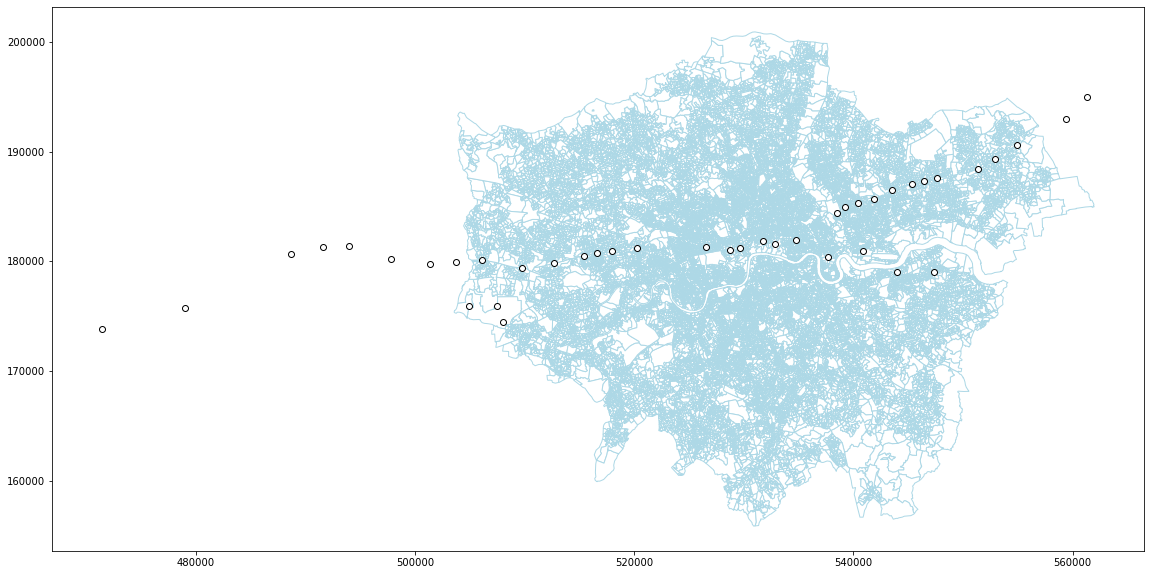

In [238]:
# Plot the stations on the map
# Create a figure and axis
fig, ax = plt.subplots(1,1, figsize=(25,10))

# Plot the OA London boundaries
London.to_crs('epsg:27700').plot(edgecolor='lightblue', facecolor='white', ax=ax)

# Plot the Elizabeth Line stations
el_station.to_crs('epsg:27700').plot(edgecolor='black', facecolor='white', ax=ax)

In [239]:
# Reset the row width
pd.reset_option('^display.', silent=True)

In [240]:
# Check the airbnb listings in 2022
airbnb_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67832 entries, 0 to 69350
Data columns (total 71 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            67832 non-null  int64  
 1   listing_url                                   67832 non-null  object 
 2   scrape_id                                     67832 non-null  int64  
 3   last_scraped                                  67832 non-null  object 
 4   source                                        67832 non-null  object 
 5   name                                          67812 non-null  object 
 6   description                                   67832 non-null  object 
 7   neighborhood_overview                         39868 non-null  object 
 8   picture_url                                   67832 non-null  object 
 9   host_id                                       67832 non-null 

In [241]:
# Drop columns that are entirely null or None
airbnb_22 = airbnb_22.dropna(axis=1, how='all')

In [242]:
# Check the price data since it is object
airbnb_22.price

0         50.0
1         75.0
2         90.0
3         55.0
4        379.0
         ...  
69346     55.0
69347    201.0
69348    246.0
69349    250.0
69350    134.0
Name: price, Length: 67832, dtype: float64

In [243]:
# Replace the unit and change it to numerical for further calculations
# Only process x if it is str
airbnb_22['price'] = airbnb_22['price'].apply(lambda x: float(re.sub(r'[$,]', '', x) if isinstance(x, str) else x)) 
airbnb_22.price

0         50.0
1         75.0
2         90.0
3         55.0
4        379.0
         ...  
69346     55.0
69347    201.0
69348    246.0
69349    250.0
69350    134.0
Name: price, Length: 67832, dtype: float64

In [244]:
# Extract the needed information
airbnb_22_price = airbnb_22.loc[:,['id', 'price', 'longitude', 'latitude']]
airbnb_22_price.head()

,id,price,longitude,latitude
0,13913,50.0,-0.11270,51.56861
1,15400,75.0,-0.16813,51.48780
2,284532,90.0,-0.07426,51.52851
3,106332,55.0,-0.05396,51.52874
4,17402,379.0,-0.14094,51.52195


In [245]:
# Make the airbnb 2022 data as point pattern
airbnb_22_point = gpd.GeoDataFrame(airbnb_22_price, 
      geometry=gpd.points_from_xy(airbnb_22_price.longitude, airbnb_22_price.latitude, crs='epsg:4326'))

# Change the CRS to EPSG 27700
airbnb_22_point = airbnb_22_point.to_crs('EPSG:27700')

In [246]:
# Check the data
airbnb_22_point.sample(n=10,random_state=100)

,id,price,longitude,latitude,geometry
14578,15717701,40.0,-0.008000,51.499700,POINT (538365.535 179743.315)
32663,31902270,85.0,-0.151610,51.574590,POINT (528187.656 187809.916)
31214,30317505,36.0,-0.110710,51.423790,POINT (531454.582 171112.932)
54344,546003436065611887,75.0,-0.064010,51.479570,POINT (534537.299 177400.503)
56269,590494832845187220,60.0,-0.051230,51.532027,POINT (535269.375 183257.414)
63948,675721740399637975,100.0,-0.053957,51.547701,POINT (535033.849 184995.357)
28149,27095286,80.0,-0.200540,51.523990,POINT (524935.552 182098.363)
54261,538251585285658710,1570.0,-0.208880,51.524770,POINT (524354.877 182170.908)
55335,575893889457714372,100.0,-0.325170,51.507760,POINT (516331.128 180088.243)
34118,33577680,350.0,-0.147660,51.516370,POINT (528625.309 181342.524)


In [247]:
# Check the column names
airbnb_22_point.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67832 entries, 0 to 69350
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         67832 non-null  int64   
 1   price      67832 non-null  float64 
 2   longitude  67832 non-null  float64 
 3   latitude   67832 non-null  float64 
 4   geometry   67832 non-null  geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 3.1 MB


<AxesSubplot:>

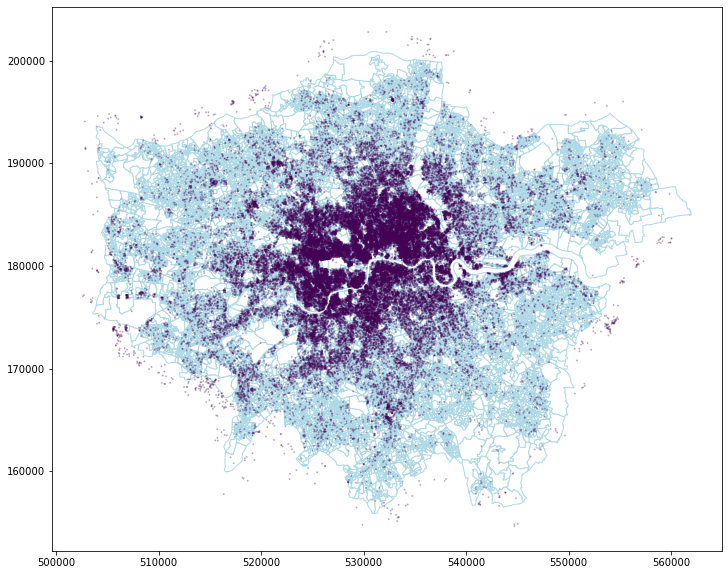

In [248]:
# Plot the Airbnb listing points in London boundaries
# Create a figure and axis
fig, ax = plt.subplots(1,1, figsize=(25,10))

# Plot the OA London boundaries
London.to_crs(epsg=27700).plot(edgecolor='lightblue', facecolor='white', ax=ax)

# Plot the 2022 airbnb listing points and coloured by their price
airbnb_22_point.to_crs(epsg=27700).plot(column='price', cmap='viridis', alpha=0.25, markersize=1, ax=ax)

In [249]:
zones = zones_raw.copy()
zones.head()

,OA11CD,Fare_Zone
0,E00000001,1
1,E00000003,1
2,E00000005,1
3,E00000007,1
4,E00000010,1


In [250]:
# Check the London boundaries
London.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,Wandsworth 032,462,459,3,115.2,143,3.2,"POLYGON ((527635.452 171810.058, 527495.957 17..."
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,Bromley 002,269,259,10,36.7,133,1.9,"POLYGON ((543581.516 171132.486, 543704.000 17..."
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,Wandsworth 034,277,277,0,183.4,133,2.1,"POLYGON ((526613.539 171839.165, 526546.840 17..."
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,Southwark 003,415,415,0,96.1,191,2.2,"POLYGON ((533563.521 179695.146, 533351.118 17..."
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,Wandsworth 033,304,304,0,165.2,131,2.3,"POLYGON ((527822.000 172020.000, 527979.000 17..."


In [251]:
# Left join the OA London boundaries and the fare zones
London_zones = London.merge(zones, on='OA11CD', how='left')

# Rename the new column to Zone
London_zones = London_zones.rename(columns={'Fare_Zone': 'Zone'})
London_zones.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,Zone
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,Wandsworth 032,462,459,3,115.2,143,3.2,"POLYGON ((527635.452 171810.058, 527495.957 17...",3
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,Bromley 002,269,259,10,36.7,133,1.9,"POLYGON ((543581.516 171132.486, 543704.000 17...",4
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,Wandsworth 034,277,277,0,183.4,133,2.1,"POLYGON ((526613.539 171839.165, 526546.840 17...",3
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,Southwark 003,415,415,0,96.1,191,2.2,"POLYGON ((533563.521 179695.146, 533351.118 17...",1
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,Wandsworth 033,304,304,0,165.2,131,2.3,"POLYGON ((527822.000 172020.000, 527979.000 17...",3


In [252]:
# Join the airbnb listing points that are within the boundaries
London_zones_airbnb_22 = gpd.sjoin(airbnb_22_point,London_zones, how="left")

In [253]:
London_zones_airbnb_22.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67832 entries, 0 to 69350
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           67832 non-null  int64   
 1   price        67832 non-null  float64 
 2   longitude    67832 non-null  float64 
 3   latitude     67832 non-null  float64 
 4   geometry     67832 non-null  geometry
 5   index_right  67087 non-null  float64 
 6   OA11CD       67087 non-null  object  
 7   LSOA11CD     67087 non-null  object  
 8   MSOA11CD     67087 non-null  object  
 9   WD11CD_BF    67087 non-null  object  
 10  WD11NM_BF    67087 non-null  object  
 11  LAD11CD      67087 non-null  object  
 12  LAD11NM      67087 non-null  object  
 13  RGN11CD      67087 non-null  object  
 14  RGN11NM      67087 non-null  object  
 15  LSOA11NM     67087 non-null  object  
 16  MSOA11NM     67087 non-null  object  
 17  USUALRES     67087 non-null  float64 
 18  HHOLDRES     67087

<AxesSubplot:>

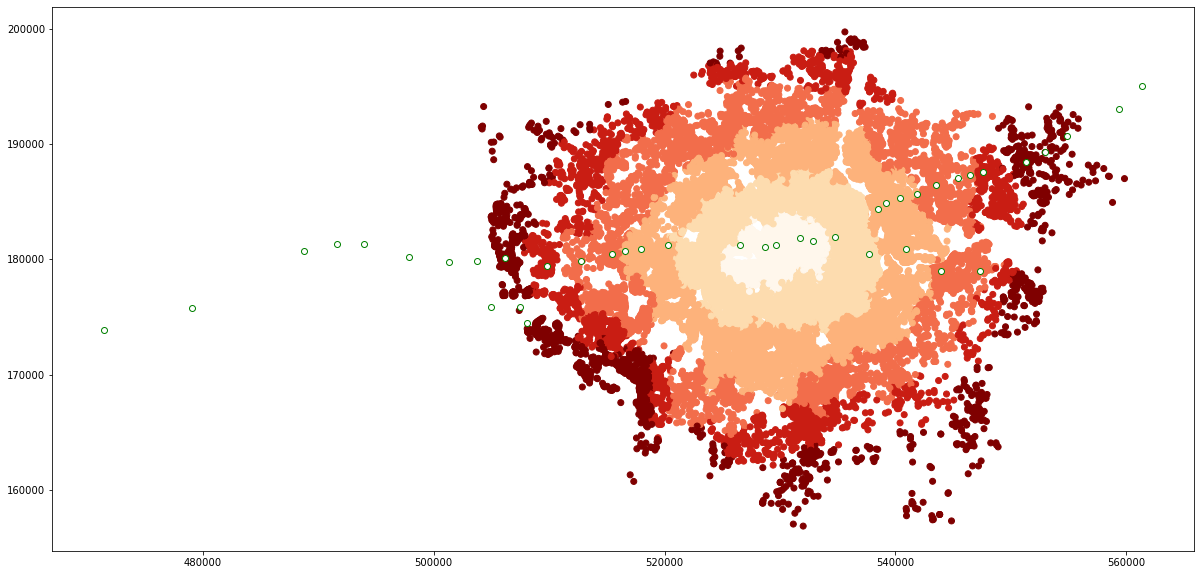

In [254]:
# Plot the merged shapes
# Create a figure and axis
fig, ax = plt.subplots(1,1, figsize=(25,10))

London_zones_airbnb_22.to_crs('epsg:27700').plot(column='Zone',cmap='OrRd', ax=ax)

# Add the Elizabeth Line stations
el_station.to_crs('epsg:27700').plot(edgecolor='green', facecolor='white', ax=ax)

In [255]:
# Group the data by the "Zone" column
zone_grouped_London_22 = London_zones_airbnb_22.groupby('Zone')

# Calculate the median of each group
zone_grouped_London_22 = London_zones_airbnb_22.groupby(['Zone'])
zone_grouped_price_22 = zone_grouped_London_22['price'].median()
zone_grouped_price_22

Zone
1.0    168.0
2.0     95.0
3.0     80.0
4.0     70.0
5.0     69.0
6.0     72.0
Name: price, dtype: float64

In [256]:
# Do the same process to get the median price per zone in 2020 listings
# Check the airbnb listings in 2020
airbnb_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71329 entries, 0 to 74187
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            71327 non-null  float64
 1   listing_url                                   71328 non-null  object 
 2   scrape_id                                     71328 non-null  object 
 3   last_scraped                                  71328 non-null  object 
 4   name                                          71310 non-null  object 
 5   description                                   71329 non-null  object 
 6   neighborhood_overview                         47133 non-null  object 
 7   picture_url                                   71329 non-null  object 
 8   host_id                                       71329 non-null  float64
 9   host_url                                      71329 non-null 

In [257]:
# Drop columns that are entirely null or None
airbnb_20 = airbnb_20.dropna(axis=1, how='all')

In [258]:
# Check the price data since it is object
airbnb_20.price

0         87.0
1         49.0
2         75.0
3        208.0
4        150.0
         ...  
74183     55.0
74184    200.0
74185    150.0
74186     23.0
74187     80.0
Name: price, Length: 71329, dtype: float64

In [259]:
# Replace the unit and change it to numerical for further calculations
airbnb_20['price'] = airbnb_20['price'].apply(lambda x: float(re.sub(r'[$,]', '', x)) if isinstance(x, str) else x)
airbnb_20.price

0         87.0
1         49.0
2         75.0
3        208.0
4        150.0
         ...  
74183     55.0
74184    200.0
74185    150.0
74186     23.0
74187     80.0
Name: price, Length: 71329, dtype: float64

In [260]:
# Extract the needed information
airbnb_20_price = airbnb_20.loc[:,['id', 'price', 'longitude', 'latitude']]
airbnb_20_price.head()

,id,price,longitude,latitude
0,11551.0,87.0,-0.11732,51.46225
1,13913.0,49.0,-0.11121,51.56802
2,15400.0,75.0,-0.16898,51.48796
3,17402.0,208.0,-0.14094,51.52195
4,17506.0,150.0,-0.19743,51.47935


In [261]:
# Make the airbnb 2020 data as point pattern
airbnb_20_point = gpd.GeoDataFrame(airbnb_20_price, 
      geometry=gpd.points_from_xy(airbnb_20_price.longitude, airbnb_20_price.latitude, crs='epsg:4326'))

# Change the CRS to EPSG 27700
airbnb_20_point = airbnb_20_point.to_crs('EPSG:27700')

In [262]:
# Check the data
airbnb_20_point.sample(n=10,random_state=100)

,id,price,longitude,latitude,geometry
41036,28238803.0,189.0,-0.16187,51.49547,POINT (527697.762 178993.504)
57854,38272207.0,160.0,-0.19115,51.49182,POINT (525675.356 178536.980)
22813,17892120.0,76.0,-0.14274,51.48980,POINT (529041.641 178396.498)
52887,35563579.0,40.0,-0.05601,51.53790,POINT (534920.497 183901.658)
32340,22653411.0,165.0,-0.12572,51.44947,POINT (530337.995 173941.805)
27106,20111144.0,100.0,-0.08622,51.38291,POINT (533275.875 166611.218)
41752,28719473.0,75.0,-0.13950,51.59724,POINT (528962.698 190349.989)
48199,32812673.0,335.0,-0.12545,51.55936,POINT (530043.779 186162.419)
59486,39050798.0,55.0,0.01247,51.48231,POINT (539839.435 177848.394)
21379,16944003.0,63.0,-0.00365,51.50764,POINT (538643.366 180634.481)


In [263]:
# Check the column names
airbnb_20_point.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 71329 entries, 0 to 74187
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         71327 non-null  float64 
 1   price      71327 non-null  float64 
 2   longitude  71327 non-null  float64 
 3   latitude   71327 non-null  float64 
 4   geometry   71329 non-null  geometry
dtypes: float64(4), geometry(1)
memory usage: 5.3 MB


In [264]:
# Fail to plot the Airbnb listing points in London boundaries
# Drop the problematic rows
airbnb_20_price.drop(airbnb_20_price[(airbnb_20_price.latitude==2) | (airbnb_20_price.longitude==2)|(airbnb_20_price.latitude.isna())|(airbnb_20_price.longitude.isna())].index.array, axis=0, inplace=True)

In [265]:
# Make the airbnb 2020 data as point pattern
airbnb_20_point = gpd.GeoDataFrame(airbnb_20_price, 
      geometry=gpd.points_from_xy(airbnb_20_price.longitude, airbnb_20_price.latitude, crs='epsg:4326'))

# Change the CRS to EPSG 27700
airbnb_20_point = airbnb_20_point.to_crs('EPSG:27700')

In [266]:
# Check the data
airbnb_20_point.sample(n=10,random_state=100)

,id,price,longitude,latitude,geometry
44845,30580499.0,35.0,-0.14723,51.47708,POINT (528765.732 176974.094)
57193,37931556.0,365.0,-0.15052,51.48747,POINT (528508.083 178123.720)
65560,41528978.0,75.0,-0.13639,51.53228,POINT (529362.180 183131.630)
18428,14939248.0,38.0,-0.22598,51.54856,POINT (523104.508 184787.585)
72160,44208162.0,42.0,-0.09474,51.46174,POINT (532455.087 175361.791)
1335,707338.0,35.0,-0.14766,51.39412,POINT (528969.123 167747.981)
13686,11435597.0,100.0,-0.05379,51.50554,POINT (535170.163 180307.236)
71366,43967718.0,155.0,-0.01986,51.50117,POINT (537537.958 179884.445)
28344,20767939.0,49.0,-0.31094,51.51870,POINT (517290.561 181327.529)
63140,40520426.0,300.0,-0.11240,51.52957,POINT (531033.838 182872.923)


<AxesSubplot:>

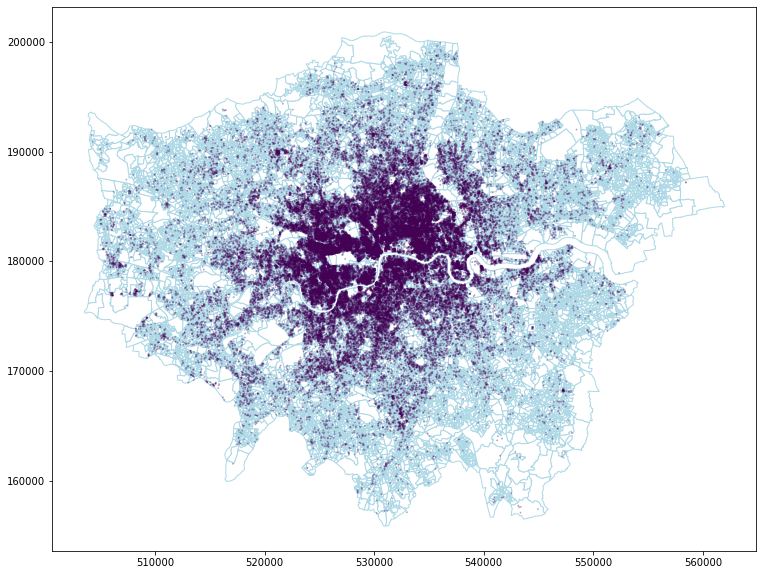

In [267]:
# Plot the Airbnb listing points in London boundaries
# Create a figure and axis
fig, ax = plt.subplots(1,1, figsize=(25,10))

# Plot the OA London boundaries
London.to_crs(epsg=27700).plot(edgecolor='lightblue', facecolor='white', ax=ax)

# Plot the 2020 airbnb listing points and coloured by their price
airbnb_20_point.to_crs(epsg=27700).plot(column='price', cmap='viridis', alpha=0.25, markersize=1, ax=ax)

In [268]:
# Join the airbnb listing points that are within the boundaries

London_zones_airbnb_20 = gpd.sjoin(airbnb_20_point,London_zones, how="left")

London_zones_airbnb_20.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 71325 entries, 0 to 74187
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           71325 non-null  float64 
 1   price        71325 non-null  float64 
 2   longitude    71325 non-null  float64 
 3   latitude     71325 non-null  float64 
 4   geometry     71325 non-null  geometry
 5   index_right  71288 non-null  float64 
 6   OA11CD       71288 non-null  object  
 7   LSOA11CD     71288 non-null  object  
 8   MSOA11CD     71288 non-null  object  
 9   WD11CD_BF    71288 non-null  object  
 10  WD11NM_BF    71288 non-null  object  
 11  LAD11CD      71288 non-null  object  
 12  LAD11NM      71288 non-null  object  
 13  RGN11CD      71288 non-null  object  
 14  RGN11NM      71288 non-null  object  
 15  LSOA11NM     71288 non-null  object  
 16  MSOA11NM     71288 non-null  object  
 17  USUALRES     71288 non-null  float64 
 18  HHOLDRES     71288

Text(0.5, 1.0, 'Location of listings per zone')

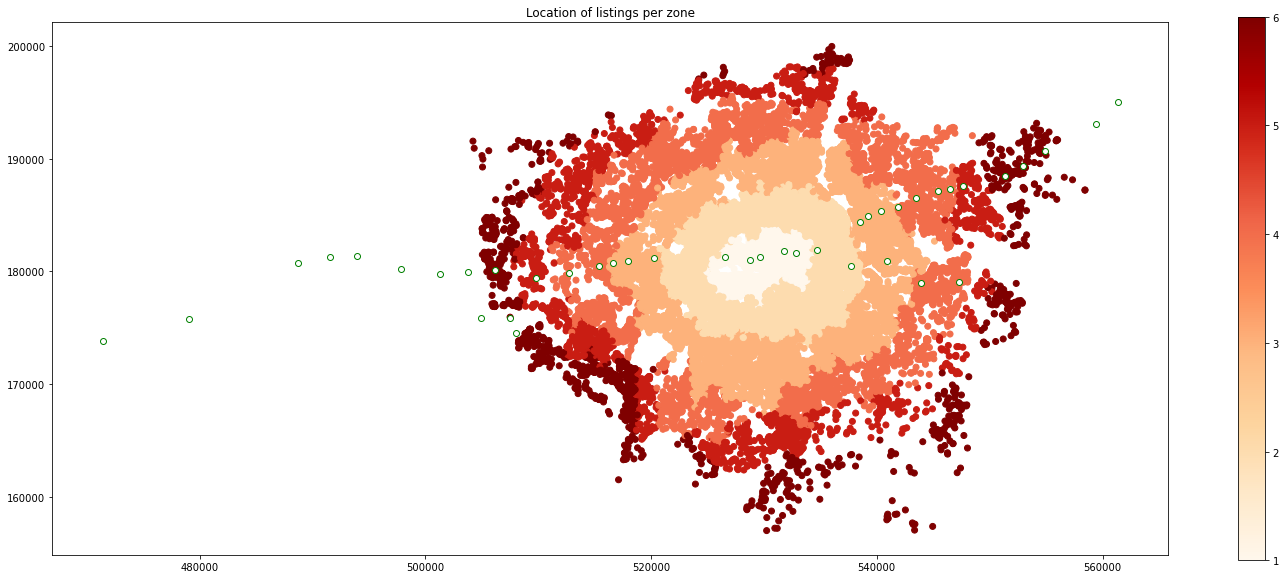

In [269]:
# Plot the merged shapes
# Create a figure and axis
fig, ax = plt.subplots(1,1, figsize=(25,10))

London_zones_airbnb_20.to_crs('epsg:27700').plot(column='Zone',
                                                 cmap='OrRd', 
                                                 ax=ax, 
                                                 legend=True)

# Add the Elizabeth Line stations
el_station.to_crs('epsg:27700').plot(edgecolor='green', facecolor='white', ax=ax)

ax.set_title('Location of listings per zone')


In [270]:
# Group the data by the "Zone" column
zone_grouped_London_20 = London_zones_airbnb_20.groupby('Zone')

# Calculate the median of each group
zone_grouped_London_20 = London_zones_airbnb_20.groupby(['Zone'])
zone_grouped_price_20 = zone_grouped_London_20['price'].median()
zone_grouped_price_20

Zone
1.0    115.0
2.0     79.0
3.0     60.0
4.0     50.0
5.0     45.0
6.0     50.0
Name: price, dtype: float64

In [271]:
# Join these two years airbnb listing price
zone_grouped_price = pd.concat([zone_grouped_price_20, zone_grouped_price_22], axis=1)

# Rename the columns
zone_grouped_price.columns = ['2020_median_price', '2022_median_price']

# Reset the index of the results to avoid zones be index
zone_grouped_price = zone_grouped_price.reset_index()

# Calculate the difference between these two years
zone_grouped_price = zone_grouped_price.assign(Difference=zone_grouped_price['2022_median_price']-zone_grouped_price['2020_median_price'])

# Calculate the Variation between these two years
zone_grouped_price['Variation'] = zone_grouped_price['Difference'] / zone_grouped_price['2022_median_price']

# Change the variation in 2 decimal places
zone_grouped_price['Variation'] = zone_grouped_price['Variation'].apply(lambda x: round(x, 2))

# Change the zone number into integer
zone_grouped_price['Zone'] = zone_grouped_price['Zone'].apply(lambda x: int(x))

# Sort the columns by variation
zone_grouped_price = zone_grouped_price.sort_values(by="Variation", ascending=False)

zone_grouped_price

,Zone,2020_median_price,2022_median_price,Difference,Variation
4,5,45.0,69.0,24.0,0.35
0,1,115.0,168.0,53.0,0.32
5,6,50.0,72.0,22.0,0.31
3,4,50.0,70.0,20.0,0.29
2,3,60.0,80.0,20.0,0.25
1,2,79.0,95.0,16.0,0.17


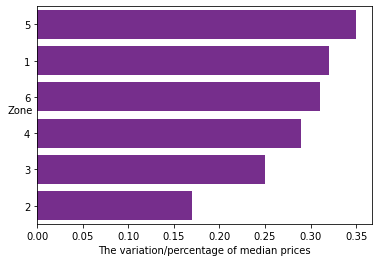

In [272]:
# Plot the variation per zone
sns.set_palette("colorblind")
sns.barplot(data=zone_grouped_price, x='Variation', y='Zone', color='xkcd:purple', order=zone_grouped_price.sort_values('Variation', ascending = False).Zone, orient='h')

# Label the x and y axes
plt.xlabel("The variation/percentage of median prices")
plt.ylabel("Zone", rotation=0)

# Show the chart
plt.show()